<h2><a href="https://www.linkedin.com/in/howardroatti/">Howard Roatti</a></h2>
<h3><a href="mailto:howardcruzroatti@gmail.com">E-Mail</a></h3>

<h3> Observações </h3>
<ol>
    <li>Se deve pensar na solução proposta como uma solução que entre em produção. É importante alcançar os melhores resultados.</li>
    <li>Detecção de Fraude em Transações Financeiras</li>
    <li>Sabemos que para cada transação que é aprovada, temos 25% de lucro.</li>
    <li>Quando há fraudes aprovadas perde-se 100% do dinheiro da transação. Realizar uma análise e determinar um modelo que permita maximizar o lucro da empresa.</li>
</ol>

# Hipótese

<p>Um modelo de aprendizagem de máquina que utiliza técnicas de classificação, poderia ser treinado com um conjunto de dados históricos de transações financeiras rotuladas como "Fraude" ou "Não Fraude". Com base nesses dados, o modelo seria capaz de identificar padrões ou características nas transações que indicam se uma transação é fraudulenta ou não.</p>

<p>Para avaliar a eficácia do modelo, poderíamos medir sua precisão, recall e F1-score em um conjunto de dados de teste. Se o modelo se sair bem nesses testes, poderíamos implantá-lo em tempo real para monitorar transações em andamento e alertar os usuários sobre transações suspeitas.</p>

<p>Ainda podemos usar um modelo de decisão de negócios para determinar se as transações suspeitas devem ser bloqueadas ou não. Por exemplo, podemos ponderar o custo de bloquear uma transação legítima (25% de lucro perdido) versus permitir uma transação fraudulenta (100% de perda), a fim de tomar uma decisão de negócios informada.</p>

<p>Esta é apenas uma hipótese e o modelo real pode precisar de ajustes adicionais com base em uma análise mais detalhada dos dados e necessidades de negócios específicas.</p>

<p>As métricas de recall, F1-score, sensibilidade e precisão são medidas comumente utilizadas para avaliar a performance de modelos de classificação em problemas de detecção de fraudes. No entanto, essas métricas não são diretamente relacionadas ao lucro ou perda financeira.</p>

<p>Para utilizar essas métricas para calcular o lucro ou perda financeira, é necessário estabelecer uma relação entre as previsões do modelo (transações rotuladas como "fraude" ou "não fraude") e os resultados reais (se a transação é realmente fraudulenta ou não).</p>

<p>Supondo que cada transação não fraudulenta tem um lucro de 25% e cada transação fraudulenta tem uma perda de 100%, podemos utilizar as seguintes definições:</p>
<ul>
    <li>Verdadeiro Positivo (VP): transação classificada como fraude que é realmente fraudulenta. Nesse caso, a perda seria de 100%.</li>
    <li>Falso Positivo (FP): transação classificada como fraude que não é realmente fraudulenta. Nesse caso, não há perda ou lucro.</li>
    <li>Verdadeiro Negativo (VN): transação classificada como não fraude que é realmente não fraudulenta. Nesse caso, o lucro seria de 25%.</li>
    <li>Falso Negativo (FN): transação classificada como não fraude que é realmente fraudulenta. Nesse caso, há uma perda de 100%.</li>
</ul>
Com base nessas definições, podemos calcular as seguintes métricas:
<ul>
    <li>Recall: proporção de transações fraudulenta que foram corretamente identificadas pelo modelo. O recall é dado por VP / (VP + FN). Quanto maior o recall, menor será a quantidade de fraudes não detectadas, reduzindo a perda.</li>
    <li>Precisão: proporção de transações classificadas como fraude que são realmente fraudulentas. A precisão é dada por VP / (VP + FP). Quanto maior a precisão, menor será o número de transações legítimas bloqueadas, evitando perdas desnecessárias.</li>
    <li>F1-score: média harmônica entre recall e precisão, que considera tanto a capacidade de detectar fraudes quanto a precisão das classificações. O F1-score é dado por 2 x (precisão x recall) / (precisão + recall).</li>
    <li>Sensibilidade: proporção de transações legítimas que foram corretamente identificadas pelo modelo. A sensibilidade é dada por VN / (VN + FP). Quanto maior a sensibilidade, maior será a quantidade de transações legítimas não bloqueadas, gerando mais lucro.</li>
</ul>
<p>Essas métricas podem ser usadas para avaliar a eficácia do modelo de detecção de fraudes em termos de lucro e perda. No entanto, é importante lembrar que outros fatores, como o custo de bloquear uma transação legítima ou a gravidade das consequências de uma fraude não detectada, também devem ser considerados na tomada de decisões de negócios.</p>


In [1]:
from time import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
my_ramdom_state = 1625
np.random.seed(my_ramdom_state)

#### Métodos Reutilizáveis - Início

In [3]:
def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 
    Método para plotar um gráfico de correlações e demonstrar as forças das correlações através de elipses
    '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

In [4]:
def hist_plot(col:str, df:pd.DataFrame):
    """
    Método para plotar histogramas
    """
    sns.histplot(data=df, x=col)
    plt.show()

In [5]:
def box_plot(y:str, x:str, df:pd.DataFrame):
    """
    Método para plotar boxplot
    """
    sns.boxplot(data=df, x=x, y=y)
    plt.xlabel(["0 - Não Fraude", "1 - Fraude"])
    plt.show()

In [6]:
def count_plot(col:str, df:pd.DataFrame):
    """
    Método para postar gráfico de barras com contagem de variáveis categóricas
    """
    sns.countplot(data=df, x=col, hue="Fraude")
    plt.legend(labels=["Não Fraude", "Fraude"])
    plt.show()

In [7]:
def matrix_confusao(y_test, y_pred):
    """
    Método para geração e plotagem da matriz de confusão.
    """
    cm = confusion_matrix(y_test, y_pred) 

    sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.show()
    return cm

In [8]:
def curva_roc(modelo, X_test, y_test, y_pred):
    """
    Método para geração da AUC e plotagem da curva ROC
    """
    probs = modelo.predict_proba(X_test)
    probs = probs[:, 1]

    auc = roc_auc_score(y_test, y_pred)
    print('AUC: %.3f' % auc)
   
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
   
    plt.plot(fpr, tpr, marker='.')
    
    plt.show()
    
    return auc

In [9]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, label_valid=None, is_cross_validate:bool=False):
    """
    Método para treinamento, previsão e geração de métricas para avaliação dos modelos
    """
    t0 = time()
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    t0 = time()
    # predict the labels on validation dataset
    if is_cross_validate:
        cv = StratifiedKFold(n_splits=10)
        predictions = cross_val_predict(estimator=classifier, 
                                        X=feature_vector_valid, 
                                        y=label_valid,
                                        cv=cv,
                                        n_jobs=8
                                       )
    else:
        predictions = classifier.predict(feature_vector_valid)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
        
    report = classification_report(y_test, predictions)
    print("\033[1m" + "{:>50}".format("%s" % (report)))
    
    mat = matrix_confusao(y_test, predictions)    
    total_blocked = predictions[(predictions == 1)].size
    ratio_correct = (mat[1,1]/total_blocked) * 100
    ratio_incorrect = (mat[0,1]/total_blocked) * 100
    print(f"Quant. Transações Bloqueados: \033[48;5;0m\033[38;5;226m {total_blocked} \033[0;0m")
    print(f"Sendo {ratio_incorrect:.3f}% bloqueadas incorretamente e {ratio_correct:.3f}% bloqueadas corretamente")
    
    return predictions, classifier, train_time, test_time, total_blocked, ratio_correct, ratio_incorrect

In [10]:
def compare(df_resultados:pd.DataFrame, grupo:str='GERAL'):
    """
    Método para comparação de modelos através das métricas geradas
    """
    print(grupo)
    modelo_mais_rapido_treino      = df_resultados.loc[df_resultados['T. Treino'] == df_resultados['T. Treino'].min(), 
                                                       'Nome'].values[0]
    modelo_mais_rapido_teste       = df_resultados.loc[df_resultados['T. Teste'] == df_resultados['T. Teste'].min(), 
                                                       'Nome'].values[0]
    modelo_mais_bloqueios          = df_resultados.loc[df_resultados['Transações Bloqueadas'] == df_resultados['Transações Bloqueadas'].max(), 
                                                       'Nome'].values[0]
    modelo_mais_bloqueios_corretos = df_resultados.loc[df_resultados['% Tran. Bloq. Corretamente'] == df_resultados['% Tran. Bloq. Corretamente'].max(), 
                                                       'Nome'].values[0]
    modelo_melhor_auc = df_resultados.loc[df_resultados['auc'] == df_resultados['auc'].max(), 
                                                       'Nome'].values[0]

    print(f"Modelo com treino mais rápido: \033[1m{modelo_mais_rapido_treino}\033[0;0m")
    print(f"Modelo com teste mais rápido: \033[1m{modelo_mais_rapido_teste}\033[0;0m")
    print(f"Modelo com maior número de bloqueios: \033[1m{modelo_mais_bloqueios}\033[0;0m")
    print(f"Modelo com maior porcentagem de bloqueios corretos: \033[1m{modelo_mais_bloqueios_corretos}\033[0;0m")
    print(f"Modelo com melhor taxa de AUC: \033[1m{modelo_melhor_auc}\033[0;0m")
    
    melhores_modelos = [modelo_mais_rapido_treino, modelo_mais_rapido_teste, modelo_mais_bloqueios, modelo_mais_bloqueios_corretos, modelo_melhor_auc]
    return df_resultados.loc[df_resultados['Nome'].isin(melhores_modelos)]

#### Métodos Reutilizáveis - Fim

# Início das Análises e Transformações

In [11]:
# Carregar o dataset
df = pd.read_csv("../Datasets/MercadoLibre Inc. Data Scientist Hiring Test - Fraud Dataset - Data.csv",                   
                   thousands=',', 
                   decimal='.')

In [12]:
df.head()

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.0,0.0,7.25,37.51,1
1,0,10,29014.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,3,0.0,0.0,11.66,8.18,1
2,0,7,92.0,0,1,0.0,0.0,0,1,UY,...,0,3,1,0,2,0.0,0.0,86.97,13.96,1
3,9,16,50269.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.0,0.0,2.51,93.67,1
4,0,8,8180.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,1,0.0,0.0,25.96,135.40,1


<p>Após inspecionar as colunas, percebi que algumas colunas que deveriam ser do tipo float estavam como str e, tanto o Excel quanto Pandas, estavam entendendo que o campo era data. Dessa forma decidi por alterar o arquivo xlsx para csv utilizando o Notepad++. Com isso consegui manter os dados consistentes ao que se realmente esperava obter.</p>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       16880 non-null  int64  
 1   B       16880 non-null  int64  
 2   C       13683 non-null  float64
 3   D       16880 non-null  int64  
 4   E       16880 non-null  int64  
 5   F       16880 non-null  float64
 6   G       16880 non-null  float64
 7   H       16880 non-null  int64  
 8   I       16880 non-null  int64  
 9   J       16880 non-null  object 
 10  K       4016 non-null   float64
 11  L       16880 non-null  int64  
 12  M       16880 non-null  int64  
 13  N       16880 non-null  int64  
 14  O       16880 non-null  int64  
 15  P       16880 non-null  int64  
 16  Q       16880 non-null  float64
 17  R       16880 non-null  float64
 18  S       16880 non-null  float64
 19  Monto   16880 non-null  float64
 20  Fraude  16880 non-null  int64  
dtypes: float64(8), int64(12), object(1)

In [14]:
df.isnull().sum()

A             0
B             0
C          3197
D             0
E             0
F             0
G             0
H             0
I             0
J             0
K         12864
L             0
M             0
N             0
O             0
P             0
Q             0
R             0
S             0
Monto         0
Fraude        0
dtype: int64

In [15]:
print("Número de Amostras com Valores Ausentes para a Classe Não Fraude (0)")
df.loc[df.Fraude == 0, ['C', 'K']].isnull().sum()

Número de Amostras com Valores Ausentes para a Classe Não Fraude (0)


C    2644
K    9706
dtype: int64

In [16]:
print("Número de Amostras com Valores Ausentes para a Classe Fraude (1)")
df.loc[df.Fraude == 1, ['C', 'K']].isnull().sum()

Número de Amostras com Valores Ausentes para a Classe Fraude (1)


C     553
K    3158
dtype: int64

<p>Existe um volume alto de valores ausentes na coluna <strong>K</strong>, cerca de <strong>~76.2%</strong>.</p>
<p>Existe um volume baixo de valores ausentes na coluna <strong>C</strong>, cerca de <strong>~19.0%</strong>.</p>
<p>Há algumas estratégias que podem ser aplicadas para essas colunas com valores ausentes:</p>
<ol>
    <li>Remover a coluna por completo.</li>
    <li>Substituir os valores ausentes por medidas de localização: média e mediana</li>
    <li>Aplicar um modelo para prever os valores ausentes baseado nas amostras que possuem os valores presentes</li>
</ol>
<p>Para o campo <strong>C</strong>, a sugestão é <i>experimentar as duas últimas estratégias</i></p>
<p>Já para o campo <strong>K</strong>, a sugestão é <i>remover a coluna por completo</i></p>
<p>Visto que, por classe, o volume de valores ausentes na coluna <strong>K</strong> pertence à classe <strong>Não Fraude (0)</strong> e o objetivo é a detecção de Fraude, é possível que o campo não interfira nos resultados.</p>

<p>Remove a coluna K</p>

In [17]:
df = df.drop(columns=["K"])

<p>Aplica uma codificação para o campo categórico J (Sigla dos Países)</p>
<p>Para não aumentar o número de colunas e interferir na perfomance do modelo, não escolhi nesse momento o one-hot-encoder. Preferi utilizar o OrdinalEncoder para sugerir uma numeração que permita associar as siglas existentes.</p>

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df["J_enc"] = enc.fit_transform(df["J"].array.reshape(-1, 1))

<strong>Aplicação de um Modelo Regressor para Preenchimento dos Dados Ausentes - Início</strong>

<p>Para essa estratégia, escolhi o kNN Regressor, para manter os dados preenchidos o mais parecido possível, como o kNN avalia a vizinhança, suponho que ele possa entregar um melhor resultado.</p>

In [19]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 3,
                          weights = 'distance',
                          metric = 'cosine',
                          n_jobs = 4
                         )

<p>Cria uma cópia das amostras que possuem o atributo C preenchido e outra cópia com as amostras que o atributo C está ausente, para aplicar um modelo regressor para completar os valores</p>

In [20]:
df_with_C = df.loc[~df.C.isna()].copy()
df_without_C = df.loc[df.C.isna()].copy()

<p>Monta o conjunto de treino removendo o atributo C (que será prevista, ou seja, é  target) e o atributo J (que foi substituída pelo atributo J_enc)</p>

In [21]:
x_train = df_with_C.drop(columns=['C','J'])
y_train = df_with_C['C']
knn.fit(x_train, y_train)

KNeighborsRegressor(metric='cosine', n_jobs=4, n_neighbors=3,
                    weights='distance')

<p>Realiza a previsão para o Target (C) para as amostras no DataFrame que possui esses valores ausentes</p>

In [22]:
predictions = knn.predict(df_without_C.drop(columns=['C','J']))

<p>Armazena as previsões no campo C_predictions</p>

In [23]:
df_without_C["C_predictions"] = predictions

<p>Para as amostras que possuem o atributo preenchido, os valores foram repetidos no atributo C_predictions</p>

In [24]:
df_with_C["C_predictions"] = df_with_C["C"]

<p>Concatena os dois dataframes criados com valores ausentes e sem valores ausentes no campo C</p>

In [25]:
df = pd.concat([df_with_C, df_without_C])

<strong>Aplicação de um Modelo Regressor para Preenchimento dos Dados Ausentes - Fim</strong>

<p>Cria os campos C_median e C_mean, preechendo so valores ausentes por mediana e média, respectivamente</p>

In [26]:
df["C_median"] = df["C"].fillna(df["C"].median())
df["C_mean"] = df["C"].fillna(df["C"].mean())

<p>Verifica a existência de valores ausentes.</p>

In [27]:
df.isnull().sum()

A                   0
B                   0
C                3197
D                   0
E                   0
F                   0
G                   0
H                   0
I                   0
J                   0
L                   0
M                   0
N                   0
O                   0
P                   0
Q                   0
R                   0
S                   0
Monto               0
Fraude              0
J_enc               0
C_predictions       0
C_median            0
C_mean              0
dtype: int64

<p>Podemos perceber que nada foi alterado no campo C, mas criei colunas extras que poderão ser testadas nos modelos, para identificar uma possibilidade de substituição do campo.</p>

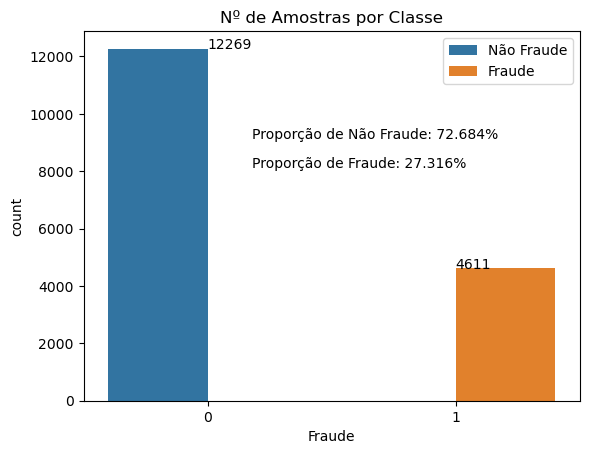

In [28]:
# Exibir a distribuição das classes da variável target
sns.countplot(x='Fraude', data=df, hue='Fraude')
plt.legend(labels=["Não Fraude", "Fraude"])
plt.title("Nº de Amostras por Classe")

total_fraud = df.loc[(df.Fraude == 1), ['Fraude']].value_counts().values[0]
total_not_fraud = df.loc[(df.Fraude == 0), ['Fraude']].value_counts().values[0]

plt.text(0, 
         total_not_fraud + 1, 
         f"{total_not_fraud}"
        )

plt.text(1, 
         total_fraud + 1, 
         f"{total_fraud}"
        )
         
total = total_fraud + total_not_fraud
fraud_ratio = round((total_fraud / total) * 100, 3)
not_fraud_ratio = round((total_not_fraud / total) * 100, 3)

plt.text(0.18,
         (total_not_fraud // 2)  + 2000,
         f"Proporção de Fraude: {fraud_ratio}%"
        )

plt.text(0.18,
         (total_not_fraud // 2) + 3000,
         f"Proporção de Não Fraude: {not_fraud_ratio}%"
        )
         
plt.show()

<p>Com o gráfico acima é possível perceber que possuímos classes desbalanceadas, o que já era de se esperar, tendo em vista que o número de transações não fraudulentas é superior ao número de transações fraudulentas.</p>
<p>Com isso em mente, surge mais possibilidades de experimentação:</p>
<ol>
    <li>Um modelo treinado com os dados na forma que estão, ou seja, desbalanceado;</li>
    <li>Um modelo treinado aplicando <strong><i>oversampling</i></strong>, ou seja, aumentando sintéticamente as amostras <strong>Fraudulentas</strong> para que o conjunto de dados se iguale em quantidade por classes;</li>
    <li>Um modelo treinado aplicando <strong><i>undersampling</i></strong>, ou seja, diminuindo as amostras <strong>Não Fraudulentas</strong> para que o conjunto de dados se iguale em quantidade por classes;</li>
</ol>

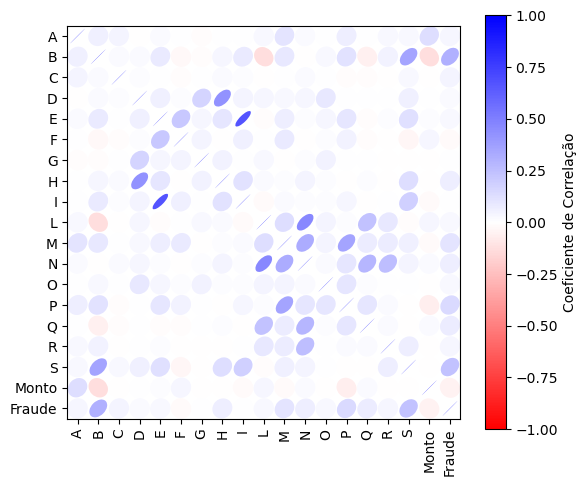

In [29]:
# Exibe a correlação entre as variáveis numéricas
m = plot_corr_ellipses(df.drop(columns=["J_enc", "C_predictions", "C_median", "C_mean"]).corr(), 
                       figsize=(6, 5), 
                       cmap='bwr_r')
cb = plt.colorbar(m)
cb.set_label('Coeficiente de Correlação')

plt.tight_layout()
plt.show()

<p>No gráfico acima, de Coeficientes de Correlação de Pearson, é possível perceber que apenas os campos I e E possuem uma correlação positiva muito forte. O restante dos campos não apresentam forte correlação. Dado a complexidade do problema, no momento decidi não fazer feature selection utilizando apenas a correlação.</p>

In [30]:
for col in ['A', 'B', 'D', 'E', 'H', 'I', 'L', 'M', 'N', 'O', 'P']:
    print(col)
    print(df[col].unique())
    print()

A
[ 0  9  1 10  2  3  4  8  5 12 30  6 20  7 27 13 14 15 11 19 17]

B
[10  7 16  8 12 18 14 17 15  3 11  9  6 13  4  5 19  2  1 20 -1]

D
[  0   1  12   4   3   2   8  27   6   7  10  16  18   9   5  33  24  20
  36  13  15 180  40  19  17  11  30  42  21  80  60]

E
[ 0  1  2  4  3  6 11 16  5  8 14  9 10 18 12 35  7 15 24 45 27 30 25]

H
[ 0  9  1  4  3 15  2  8 12  6  5  7 18 21]

I
[ 0  1  3  2  4  6  5 14 12  8 11 10  7 16  9 15 24]

L
[0 1 2 3 4 5 7 6]

M
[ 3  1  2  4  7  5  6  9  8 10 13]

N
[ 1  2  3  4  5  7  9  6 10  8]

O
[0 1 3 2]

P
[ 5  3  2  1  4  7  6  8 13 15 11 10  9 41]



<p>Devido a natureza discreta dos números inteiros existentes no conjunto de dados, decidi por alterar o tipo para categoria, para melhorar as análises e a aplicação de algoritmos.</p>

In [31]:
for _ in ['A', 'B', 'D', 'E', 'H', 'I', 'L', 'M', 'N', 'O', 'P']:
    df[_] = pd.Categorical(df[_])

In [32]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
C,13683.0,39235.339984,91045.252879,0.00,1172.0000,6173.000000,26888.500000,617324.00
F,16880.0,5.612705,37.362389,0.00,0.0000,0.000000,0.000000,667.00
G,16880.0,1.439842,19.347937,0.00,0.0000,0.000000,0.000000,667.00
Q,16880.0,8.445394,74.367729,0.00,0.0000,0.000000,0.000000,2274.67
R,16880.0,1.994921,38.222485,0.00,0.0000,0.000000,0.000000,2025.72
S,16880.0,29.127720,26.510548,-1.00,9.5600,20.640000,39.212500,99.97
Monto,16880.0,161.837033,275.499961,0.05,33.8075,81.645000,193.440000,12538.44
Fraude,16880.0,0.273164,0.445597,0.00,0.0000,0.000000,1.000000,1.00
J_enc,16880.0,2.914100,4.967466,0.00,0.0000,0.000000,2.000000,18.00
C_predictions,16880.0,39691.234849,85605.941227,0.00,1656.5000,8225.583719,32410.500000,617324.00


<p>Observando os atributos numéricos, é possível perceber a diferença de grandeza. Após a realização de alguns testes em modelos, é possível que uma melhoria a ser aplicada seja a padronização desse valores.</p>

In [33]:
df.describe(exclude='number')

,A,B,D,E,H,I,J,L,M,N,O,P
count,16880,16880,16880,16880,16880,16880,16880,16880,16880,16880,16880,16880
unique,21,21,31,23,14,17,19,8,11,10,4,14
top,0,1,0,0,0,0,AR,0,1,1,0,1
freq,14234,1342,15935,14257,16597,15998,9329,10847,11344,15767,16750,10787


In [34]:
numerical_cols = df.select_dtypes(exclude=['object']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

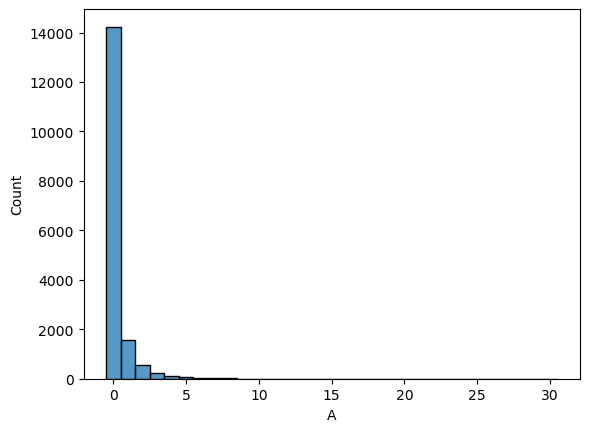

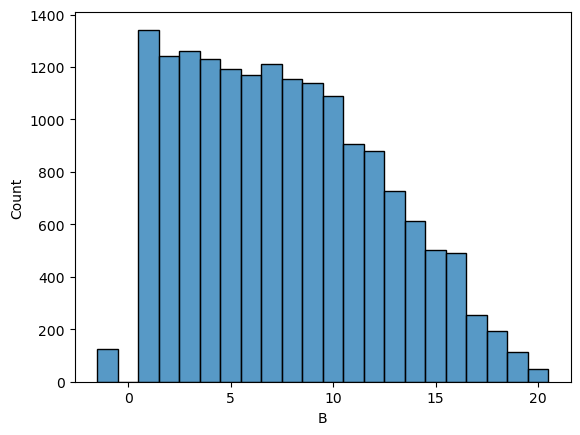

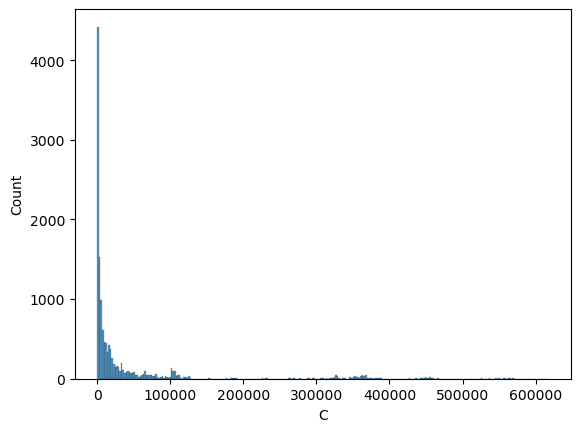

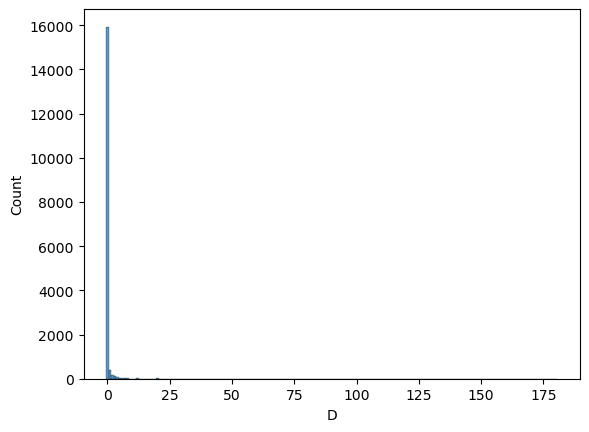

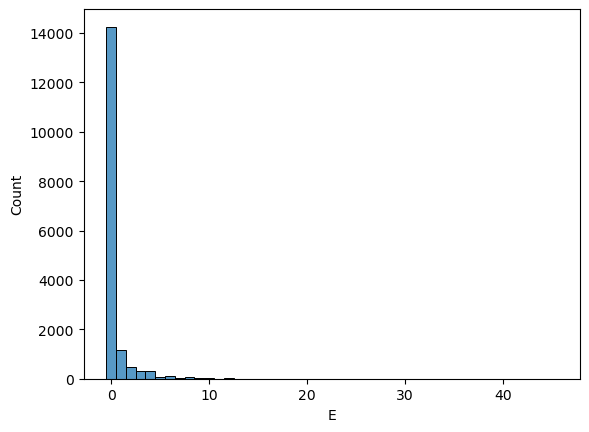

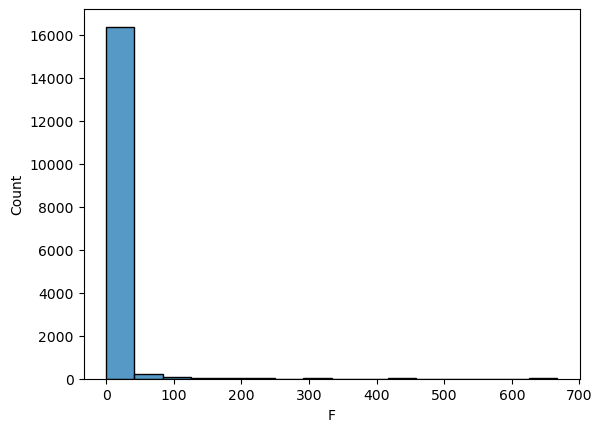

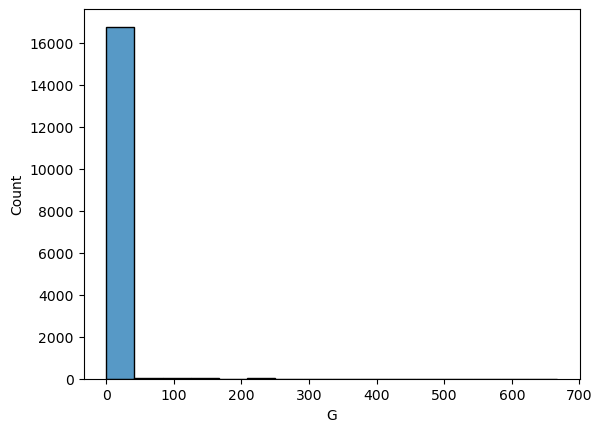

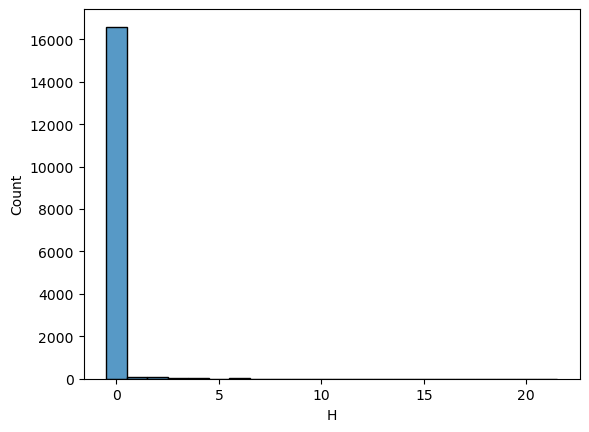

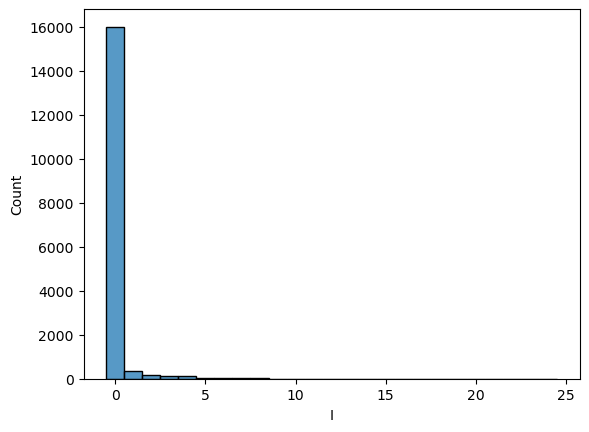

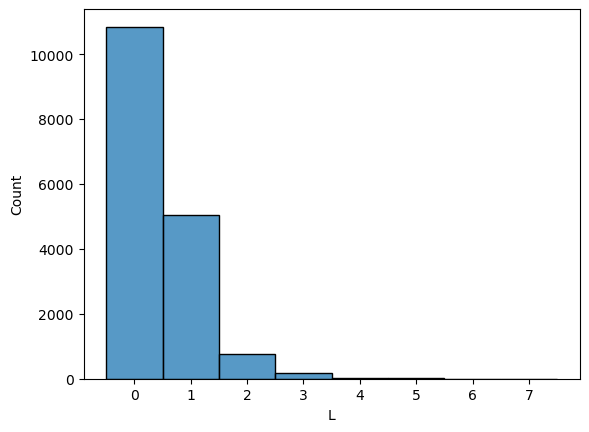

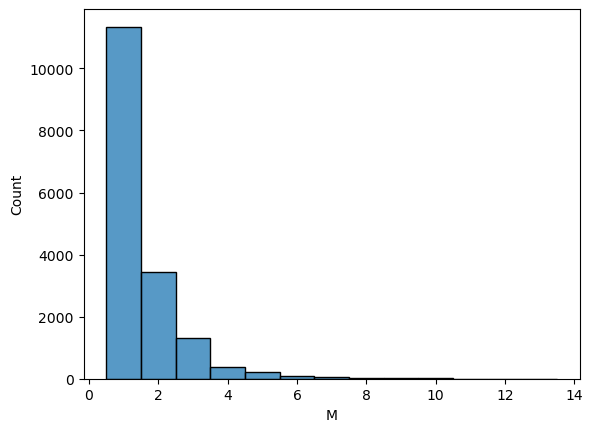

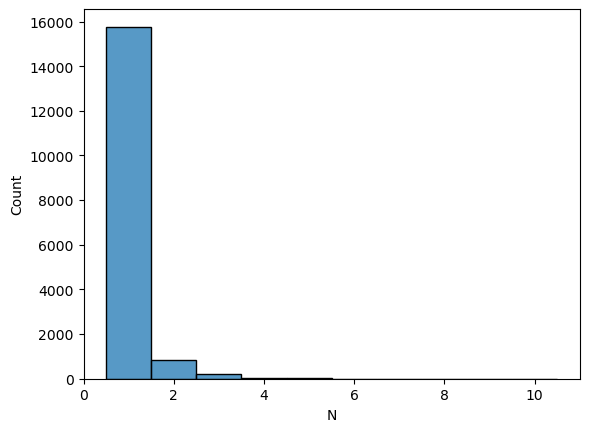

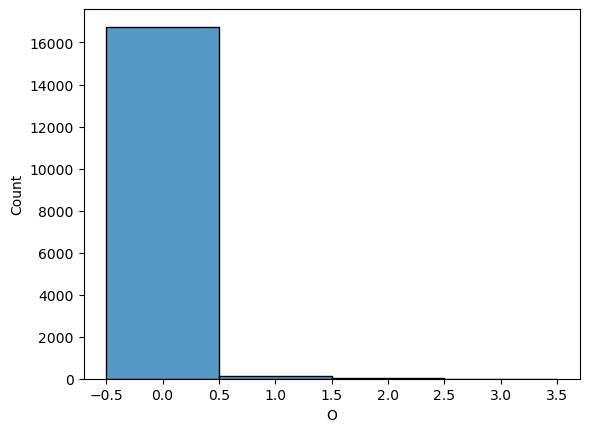

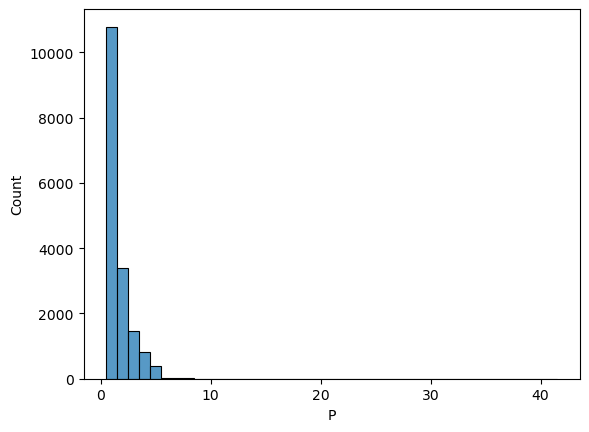

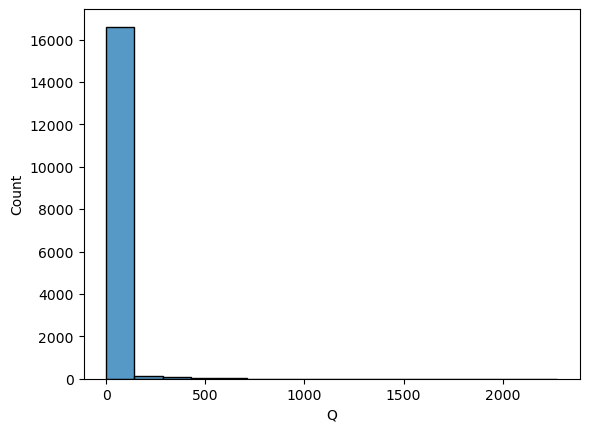

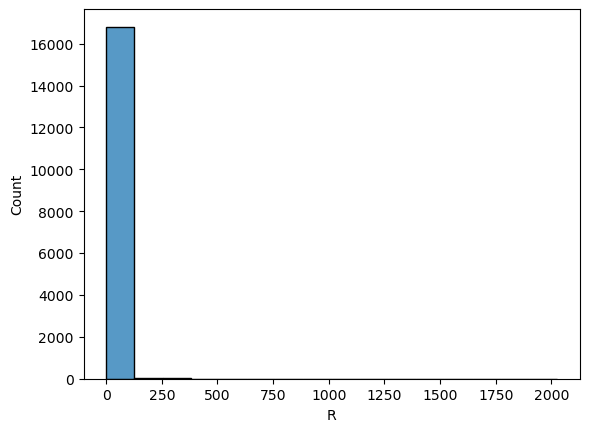

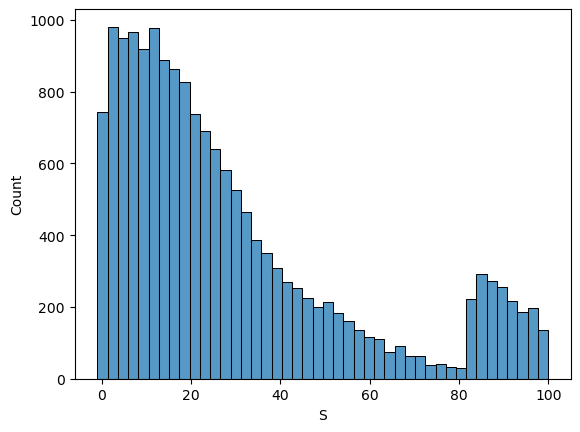

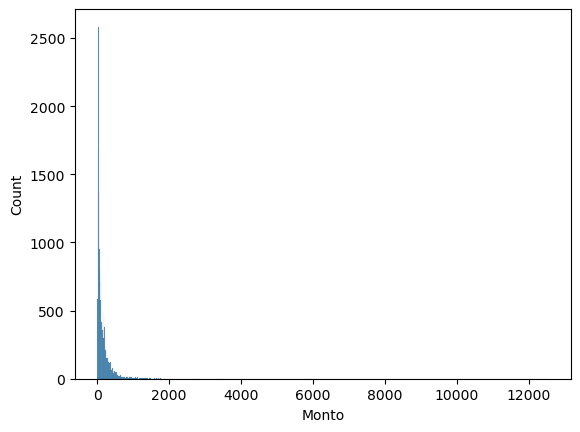

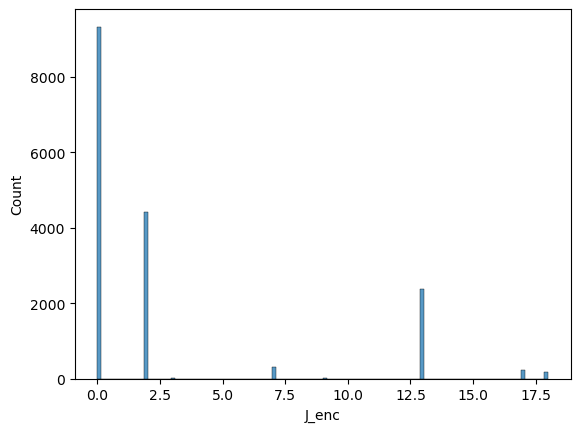

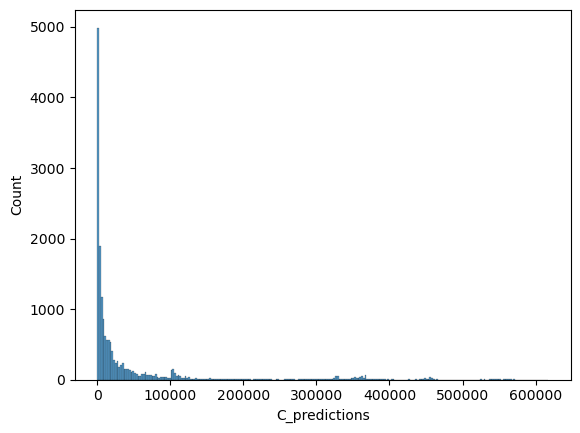

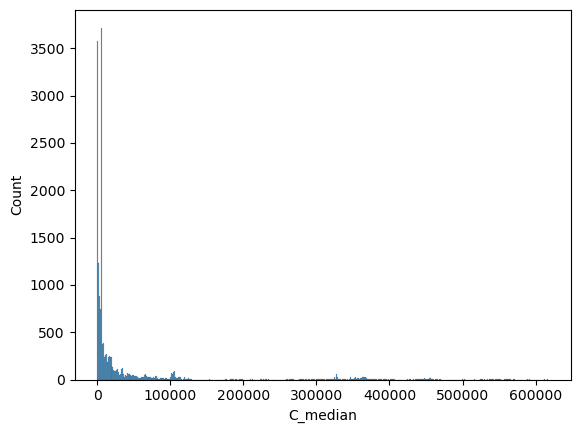

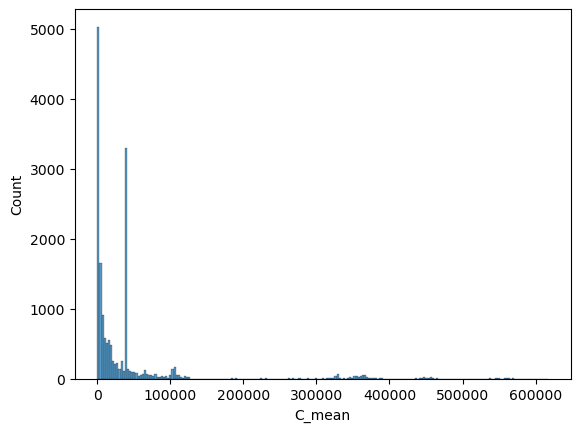

In [35]:
# Distribuição das variáveis numéricas
for c in numerical_cols:
    if c != "Fraude":
        hist_plot(col=c, df=df)

<p>Após analisar os histogramas do atributos numéricos, podemos constatar que não existe atributo que corresponda a distribuição normal. Muitos ensaio uma calda longa a direita. Outra grande parte tem sua maior frequência próximo do valor 0 (zero). Sem um dicionário de dados, é difícil tirar outras conclusões.</p>

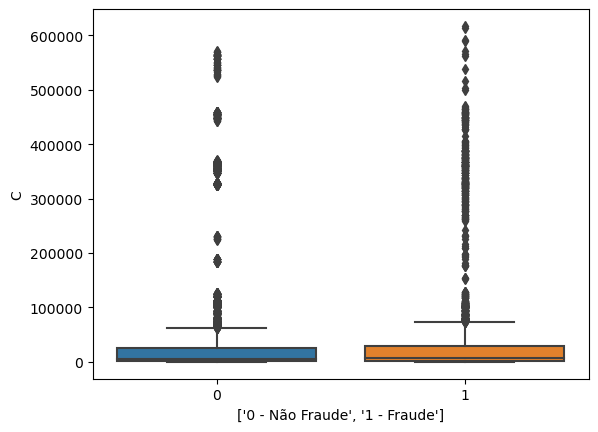

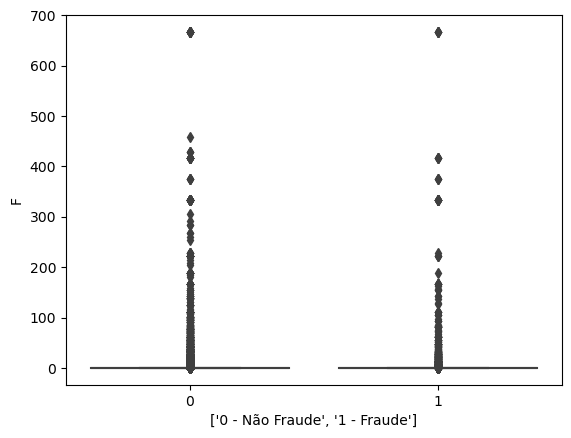

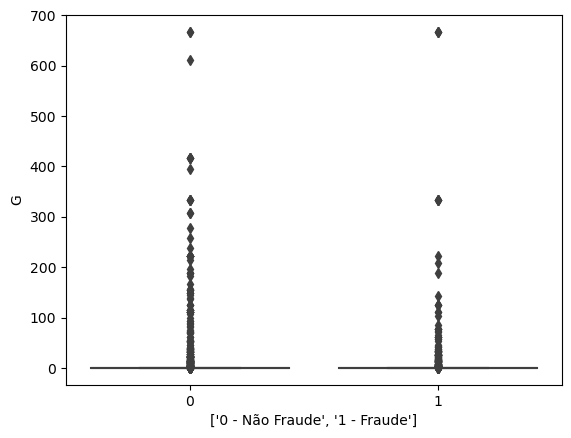

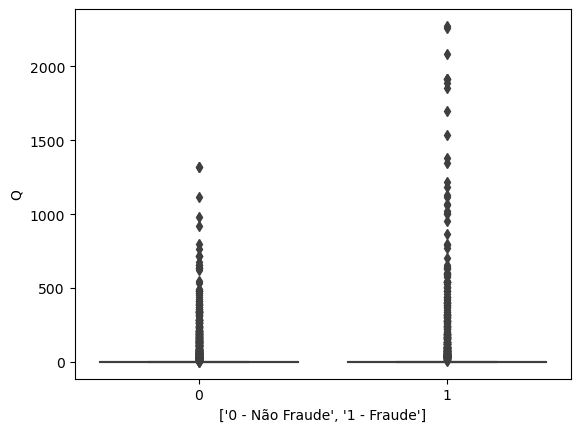

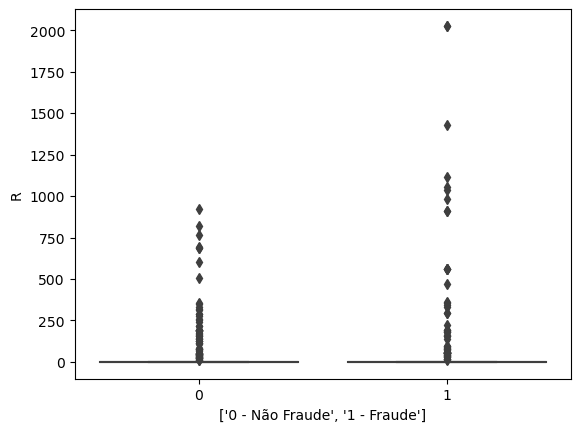

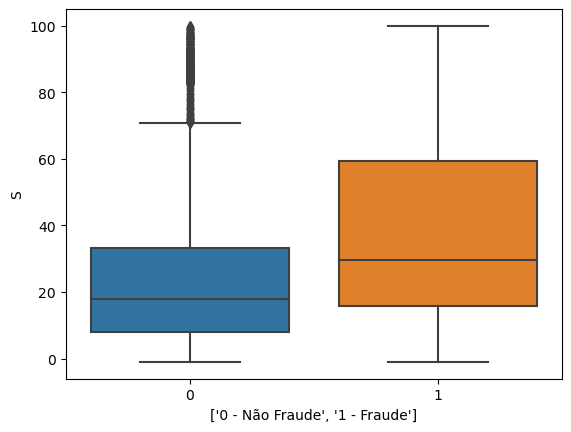

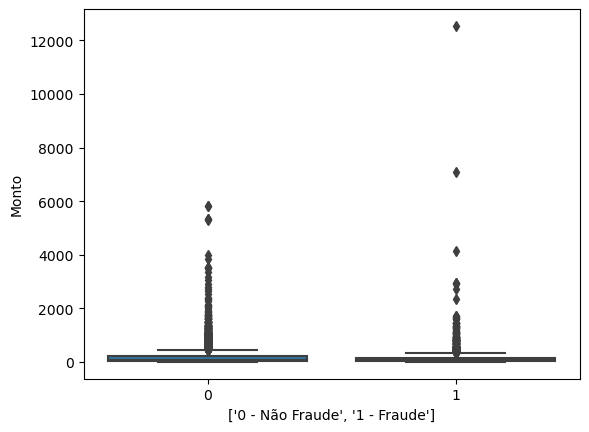

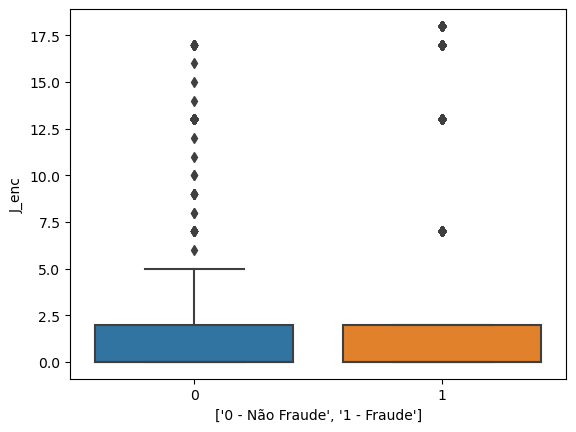

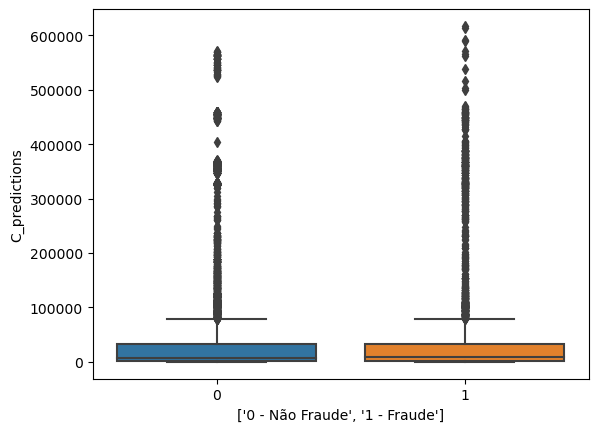

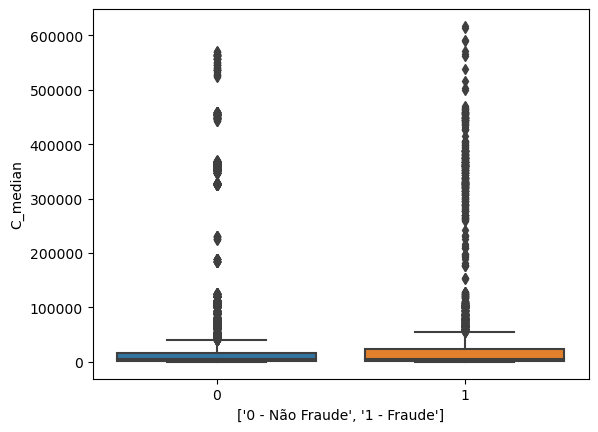

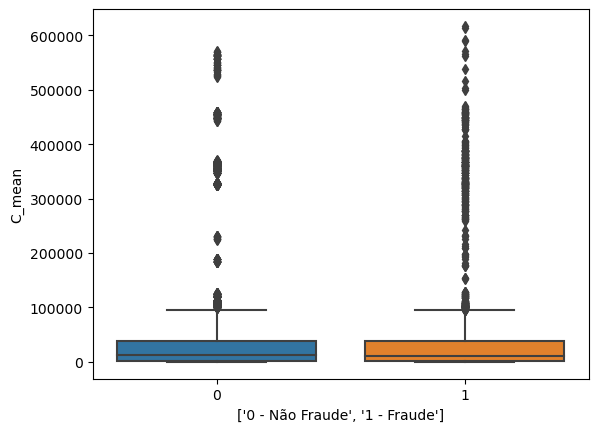

In [36]:
# Relação entre variáveis numéricas e a variável alvo (Fraude)
for c in numerical_cols:
    if c != "Fraude" and c not in categorical_cols:
        box_plot(y=c, x="Fraude", df=df)

<p>Exceto o atributo S, todos os atributos observado nos gráficos acima, possuem comportamento semelhante com 1º, 2º e 3º quartis próximos e com alguns outliers. A depender dos resultados obtidos pelos modelos, o tratamento de outliers pode resultar em melhoria das previsões, tendo e vista que os dados estarão padronizados dentro de um comportamento com pouca dispersão.</p>

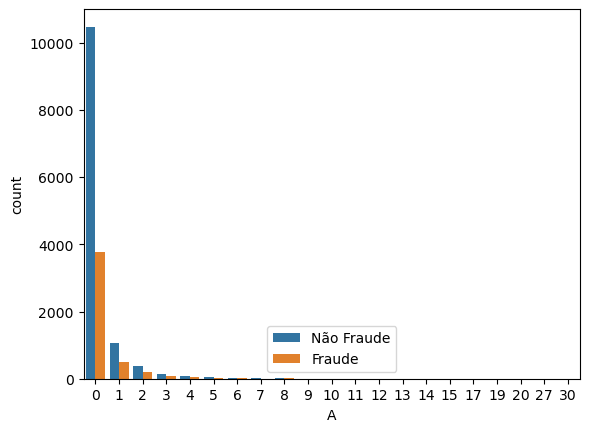

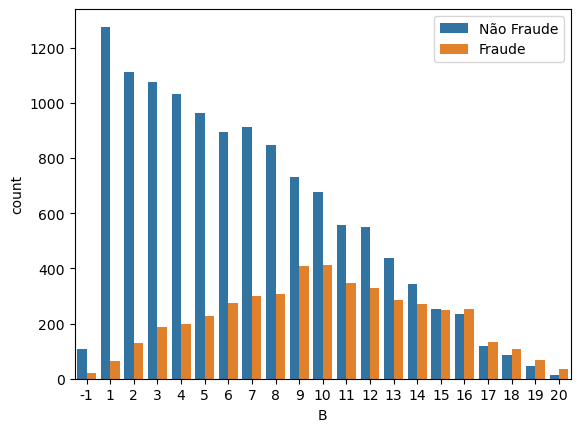

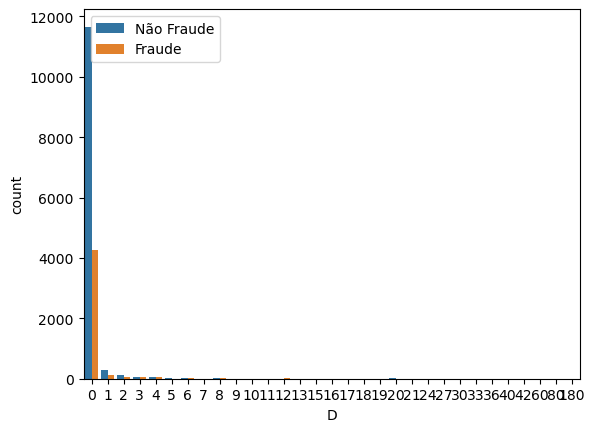

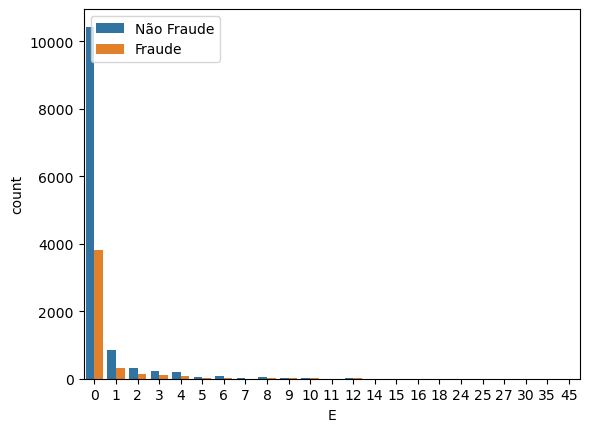

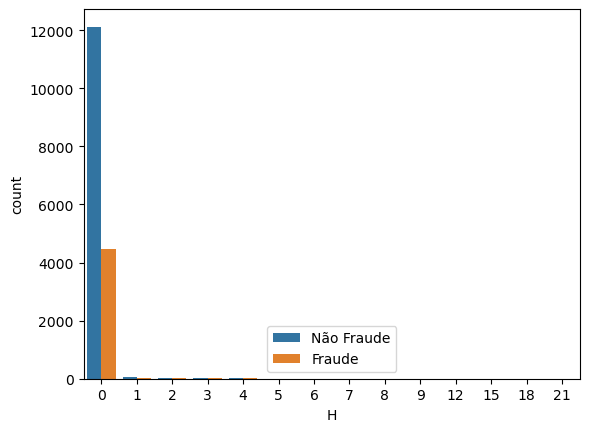

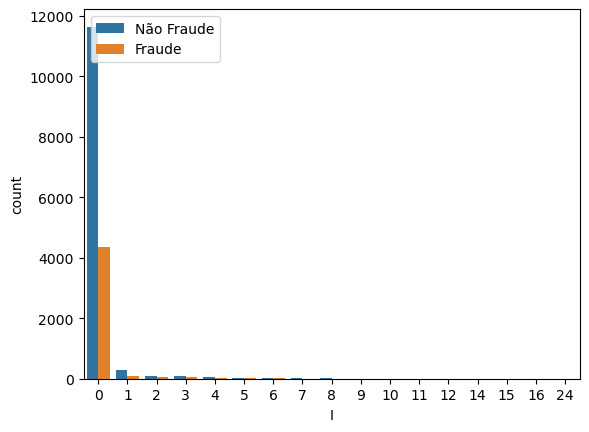

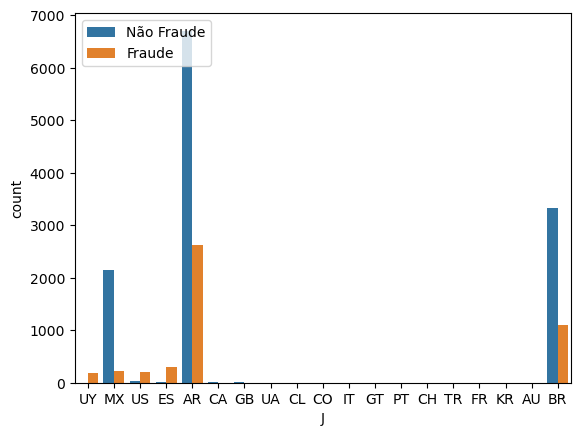

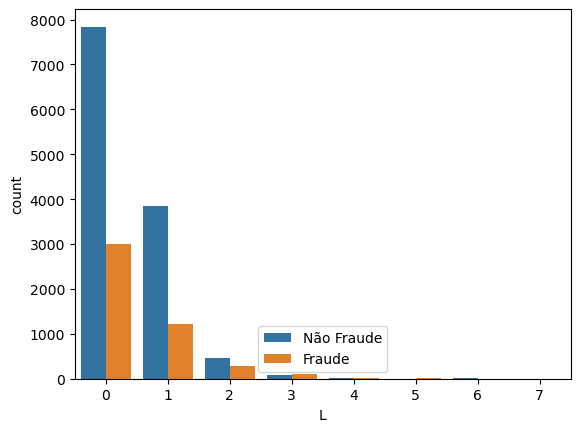

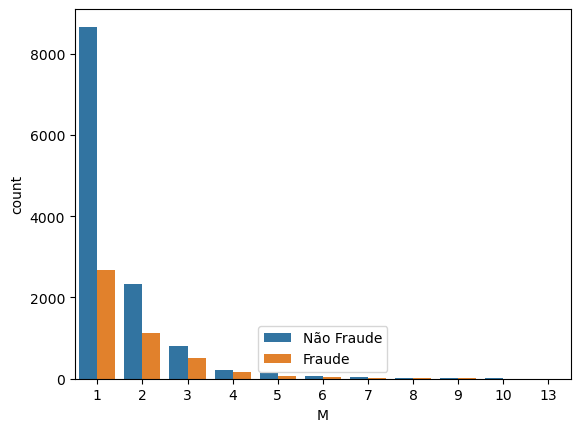

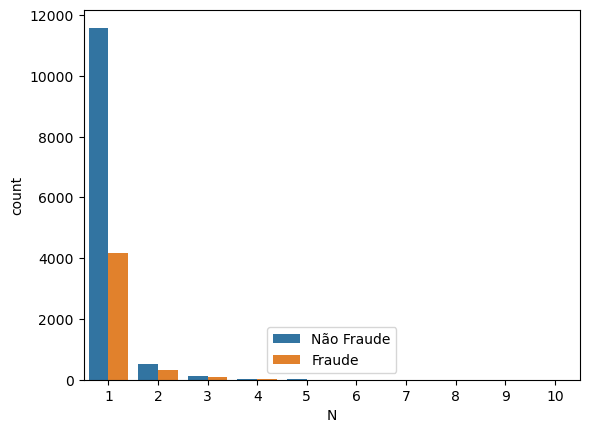

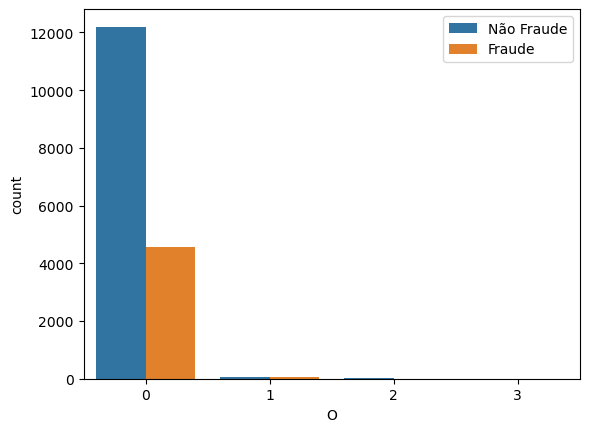

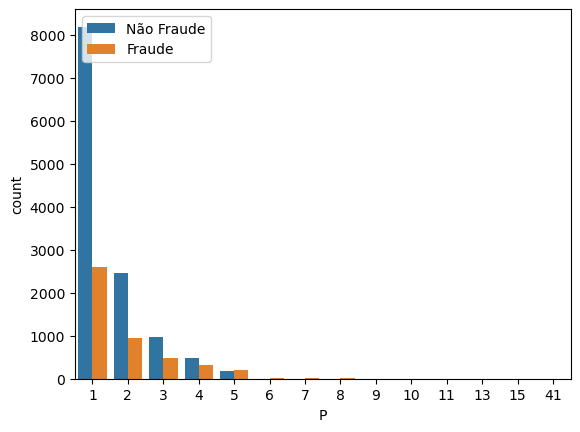

In [37]:
# Relação entre variáveis categóricas e o target (Fraude)
for c in categorical_cols:
    count_plot(col=c, df=df)

<p>Assim como os histogramas, os countplots demonstram que os atributos categóricos apresentam um comportamento de calda longa a direita. Com exceção para o atributo J, que representa os países e podemos perceber que as maiores movimentações estão no México, Argentina e Brasil, sendo que na Argentina há um maior índice de fraudes para esse conjunto de dados. Além disso, no atributo B, é possível perceber uma certa normalidade nas fraudes espalhadas pelas categorias que compõem o atributo. Já a não fraude, apresenta um comportamento similar á uma calda longa a direita, como os outros atributos.</p>

# Fim das Análises e Transformações

# Início da Modelagem

<p>Para a etapa de modelagem serão gerados 12 conjuntos de dados:</p>
<ol>
    <li>Conjunto de dados <strong>desbalanceado</strong> com valores ausentes</li>
    <li>Conjunto de dados desbalanceado com valores ausentes preenchidos com a média</li>
    <li>Conjunto de dados desbalanceado com valores ausentes preenchidos com a mediana</li>
    <li>Conjunto de dados desbalanceado com valores ausentes preenchidos por um modelo preditivo</li>    
    <li>Conjunto de dados <strong>balanceado com a técnica undersampling</strong> com valores ausentes</li>
    <li>Conjunto de dados balanceado com a técnica undersampling  com valores ausentes preenchidos com a média</li>
    <li>Conjunto de dados balanceado com a técnica undersampling  com valores ausentes preenchidos com a mediana</li>
    <li>Conjunto de dados balanceado com a técnica undersampling  com valores ausentes preenchidos por um modelo preditivo</li>    
    <li>Conjunto de dados <strong>balanceado com a técnica oversampling</strong> com valores ausentes</li>
    <li>Conjunto de dados balanceado com a técnica oversampling  com valores ausentes preenchidos com a média</li>
    <li>Conjunto de dados balanceado com a técnica oversampling  com valores ausentes preenchidos com a mediana</li>
    <li>Conjunto de dados balanceado com a técnica oversampling  com valores ausentes preenchidos por um modelo preditivo</li>
</ol>
<p>Além disso, foram selecionados os seguintes modelos baseados em árvore de decisão:</p>
<ol>
    <li><strong>XGBoost</strong></li>
    <li><strong>LGBM</strong></li>
    <li><strong>Random Forest</strong></li>
    <li><strong>Decision Tree</strong></li>
    <li><strong>Extra Trees</strong></li>
</ol>
<p>Os modelos baseados em árvore de decisão foram escolhidos pela semelhança na tomada de decisão que um especialista humano faria para indicar, baseado em regras, que uma determinada transação é ou não é fraudulenta</p>

In [38]:
# Separação das colunas para geração dos modelos de dados
target = ["Fraude"]
print(target)
missing_columns = list(set(df.columns)-set(["J", "C_predictions", "C_median", "C_mean", "Fraude"]))
print(missing_columns)
mean_columns = list(set(df.columns)-set(["J", "C_predictions", "C_median", "C", "Fraude"]))
print(mean_columns)
median_columns = list(set(df.columns)-set(["J", "C_predictions", "C", "C_mean", "Fraude"]))
print(median_columns)
predictions_columns = list(set(df.columns)-set(["J", "C", "C_median", "C_mean", "Fraude"]))
print(predictions_columns)

['Fraude']
['J_enc', 'E', 'L', 'H', 'N', 'Q', 'S', 'B', 'G', 'I', 'C', 'O', 'F', 'P', 'M', 'Monto', 'R', 'D', 'A']
['C_mean', 'J_enc', 'E', 'L', 'H', 'N', 'Q', 'S', 'B', 'G', 'I', 'O', 'F', 'P', 'M', 'Monto', 'R', 'D', 'A']
['J_enc', 'E', 'L', 'H', 'N', 'Q', 'S', 'B', 'G', 'C_median', 'I', 'O', 'F', 'P', 'M', 'Monto', 'R', 'D', 'A']
['C_predictions', 'J_enc', 'E', 'L', 'H', 'N', 'Q', 'S', 'B', 'G', 'I', 'O', 'F', 'P', 'M', 'Monto', 'R', 'D', 'A']


<p>Devido alguns modelos não trabalharem bem como o tipo category, precisei voltar para o tipo numérico. Os modelos são:</p>
<ol>
    <li><strong>Random Forest</strong></li>
    <li><strong>Decision Tree</strong></li>
    <li><strong>Extra Trees</strong></li>
</ol>

In [39]:
for _ in ['A', 'B', 'D', 'E', 'H', 'I', 'L', 'M', 'N', 'O', 'P']:
    df[_] = pd.to_numeric(df[_])

<p>Os modelos serão treinados com três tamanhos de amostras diferentes, conforme a seguir:</p>

In [40]:
# Original
print("DataSet Original")
print(df.shape)

DataSet Original
(16880, 24)


<p>Balanceamento de Classes</p>

In [41]:
# Undersampling
print("DataSet com Undersampling")
df_fraud = df[df.Fraude==1]
df_not_fraud_undersampling = df[df.Fraude==0].sample(n=df_fraud.count()[0], random_state=my_ramdom_state)
df_undersampling = pd.concat([df_fraud, df_not_fraud_undersampling])
print(df_undersampling.shape)
del df_fraud, df_not_fraud_undersampling

# Oversampling com SMOTE
X_oversampling, y_oversampling = SMOTE(random_state=my_ramdom_state).fit_resample(df.drop(columns=["C", "J", "Fraude"]), df[target])
X_oversampling["C"] = df["C"]
X_oversampling["J"] = df["J"]
print("DataSet com Oversampling")
print(X_oversampling.shape)

DataSet com Undersampling
(9222, 24)
DataSet com Oversampling
(24538, 23)


<p>Para a estratégia de undersampling, utilizei o algoritmo de reamostragem do próprio Pandas, o método <i>sample</i> que recupera amostras aleatórias.</p>
<p>Já para a estratégia de oversampling, utilizei o algoritmo SMOTE. Segue explicação do algoritmo segundo o site da Microsoft(https://learn.microsoft.com/pt-br/azure/machine-learning/component-reference/smote):</p>
<br>
<i><p>"A SMOTE (técnica de sobreamostragem minoritária sintética) é uma técnica estatística para aumentar o número de casos em seu conjunto de um modo equilibrado. O componente funciona gerando novas instâncias de casos minoritários existentes que você fornece como entrada. Essa implementação de SMOTE não muda o número de casos majoritários.</p>
<p>As novas instâncias não são apenas cópias de casos minoritários existentes. Em vez disso, o algoritmo usa exemplos do espaço de recurso para cada classe de destino e seus vizinhos mais próximos. O algoritmo, em seguida, gera novos exemplos que combinam recursos do caso de destino com recursos de seus vizinhos. Essa abordagem aumenta os recursos disponíveis para cada classe e torna os exemplos mais gerais.</p>
<p>A SMOTE usa todo o conjunto de dados como uma entrada, mas aumenta a porcentagem apenas dos casos minoritários."</p></i>

In [42]:
# Criação dos datasets para treino e teste dos modelos
X_original_missing     = df[missing_columns]
X_original_mean        = df[mean_columns]
X_original_median      = df[median_columns]
X_original_predictions = df[predictions_columns]
y_original             = df[target]

X_undersampling_missing     = df_undersampling[missing_columns]
X_undersampling_mean        = df_undersampling[mean_columns]
X_undersampling_median      = df_undersampling[median_columns]
X_undersampling_predictions = df_undersampling[predictions_columns]
y_undersampling             = df_undersampling[target]

X_oversampling_missing     = X_oversampling[missing_columns]
X_oversampling_mean        = X_oversampling[mean_columns]
X_oversampling_median      = X_oversampling[median_columns]
X_oversampling_predictions = X_oversampling[predictions_columns]
# y_oversampling

In [43]:
# Lista com os modelos que serão utilizados
estimators = [
    ("XGBoost",       XGBClassifier(random_state=my_ramdom_state)),
    ("LGBM",          LGBMClassifier(random_state=my_ramdom_state)),
    ("Random Forest", RandomForestClassifier(random_state=my_ramdom_state)),
    ("Decision Tree", DecisionTreeClassifier(random_state=my_ramdom_state)),
    ("Extra Trees",   ExtraTreesClassifier(random_state=my_ramdom_state))
]

In [44]:
# Lista com os datasets que serão utilizados para comparação dos modelos
datasets = [
    # Original
    ("Original Missing",     X_original_missing,     y_original),
    ("Original Mean",        X_original_mean,        y_original),
    ("Original Median",      X_original_median,      y_original),
    ("Original Predictions", X_original_predictions, y_original),
    # Undersampling
    ("Undersampling Missing",     X_undersampling_missing,     y_undersampling),
    ("Undersampling Mean",        X_undersampling_mean,        y_undersampling),
    ("Undersampling Median",      X_undersampling_median,      y_undersampling),
    ("Undersampling Predictions", X_undersampling_predictions, y_undersampling),
    # Oversampling
    ("Oversampling Missing",     X_oversampling_missing,     y_oversampling),
    ("Oversampling Mean",        X_oversampling_mean,        y_oversampling),
    ("Oversampling Median",      X_oversampling_median,      y_oversampling),
    ("Oversampling Predictions", X_oversampling_predictions, y_oversampling),
]

----------------------------------------------------------------------------------------------------
Início: XGBoost, Original Missing
train time: 1.744s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3662
           1       0.72      0.46      0.56      1402

    accuracy                           0.80      5064
   macro avg       0.77      0.70      0.72      5064
weighted avg       0.79      0.80      0.79      5064



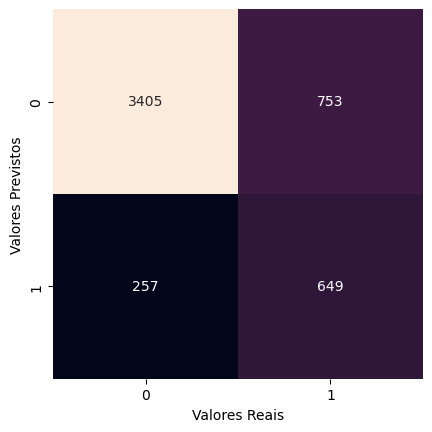

Quant. Transações Bloqueados:  906 
Sendo 28.366% bloqueadas incorretamente e 71.634% bloqueadas corretamente
AUC: 0.696


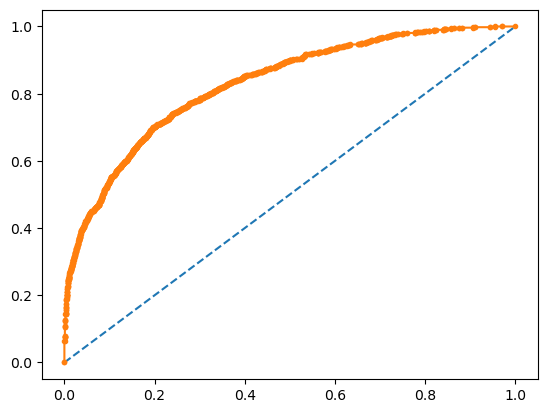

Fim: XGBoost, Original Missing
Início: XGBoost, Original Mean
train time: 0.471s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3662
           1       0.72      0.46      0.56      1402

    accuracy                           0.80      5064
   macro avg       0.77      0.69      0.71      5064
weighted avg       0.79      0.80      0.78      5064



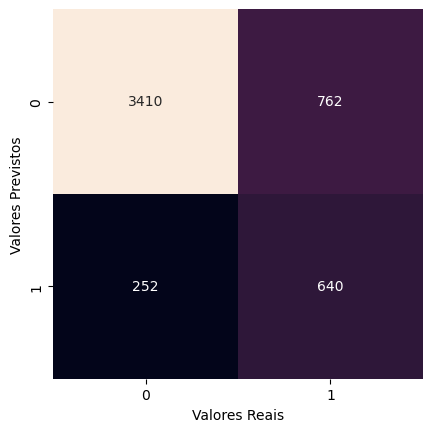

Quant. Transações Bloqueados:  892 
Sendo 28.251% bloqueadas incorretamente e 71.749% bloqueadas corretamente
AUC: 0.694


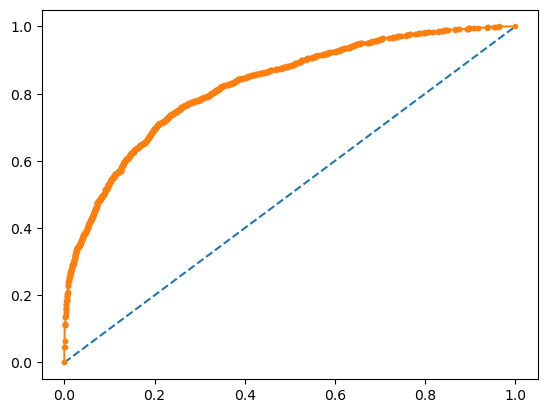

Fim: XGBoost, Original Mean
Início: XGBoost, Original Median
train time: 0.471s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      3662
           1       0.73      0.46      0.56      1402

    accuracy                           0.80      5064
   macro avg       0.77      0.70      0.72      5064
weighted avg       0.79      0.80      0.79      5064



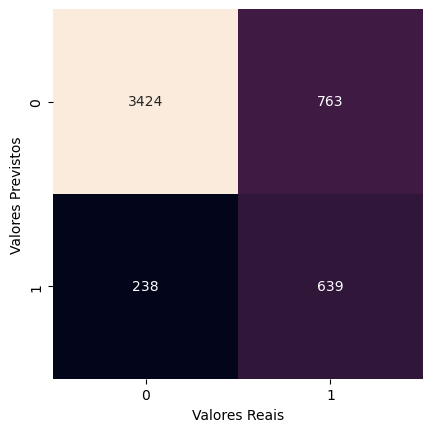

Quant. Transações Bloqueados:  877 
Sendo 27.138% bloqueadas incorretamente e 72.862% bloqueadas corretamente
AUC: 0.695


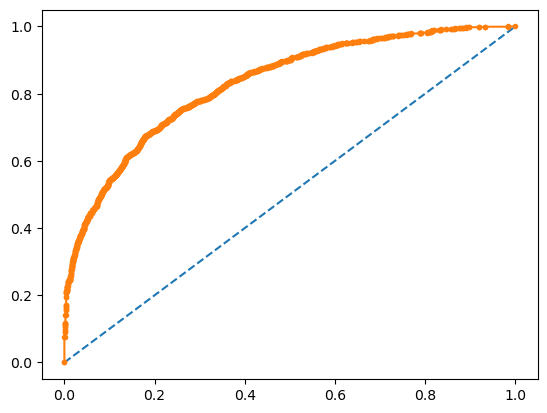

Fim: XGBoost, Original Median
Início: XGBoost, Original Predictions
train time: 0.486s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3662
           1       0.72      0.44      0.55      1402

    accuracy                           0.80      5064
   macro avg       0.77      0.69      0.71      5064
weighted avg       0.79      0.80      0.78      5064



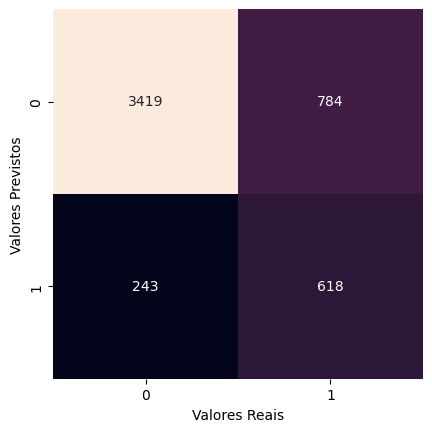

Quant. Transações Bloqueados:  861 
Sendo 28.223% bloqueadas incorretamente e 71.777% bloqueadas corretamente
AUC: 0.687


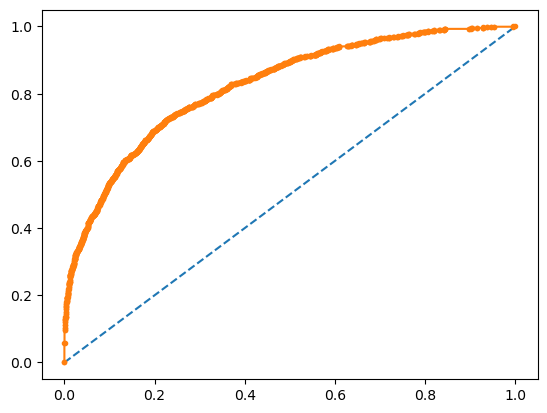

Fim: XGBoost, Original Predictions
Início: XGBoost, Undersampling Missing
train time: 0.363s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1371
           1       0.74      0.72      0.73      1396

    accuracy                           0.73      2767
   macro avg       0.73      0.73      0.73      2767
weighted avg       0.73      0.73      0.73      2767



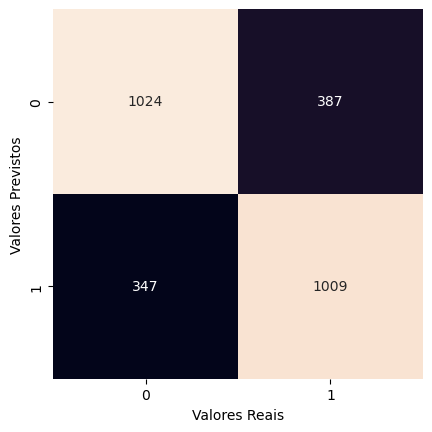

Quant. Transações Bloqueados:  1356 
Sendo 25.590% bloqueadas incorretamente e 74.410% bloqueadas corretamente
AUC: 0.735


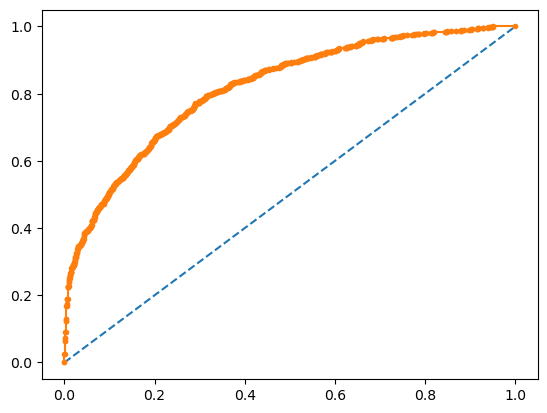

Fim: XGBoost, Undersampling Missing
Início: XGBoost, Undersampling Mean
train time: 0.298s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1371
           1       0.75      0.72      0.73      1396

    accuracy                           0.74      2767
   macro avg       0.74      0.74      0.74      2767
weighted avg       0.74      0.74      0.74      2767



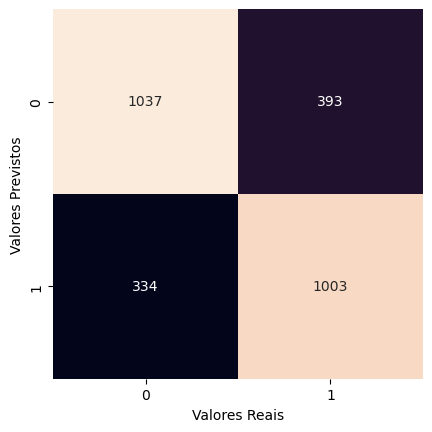

Quant. Transações Bloqueados:  1337 
Sendo 24.981% bloqueadas incorretamente e 75.019% bloqueadas corretamente
AUC: 0.737


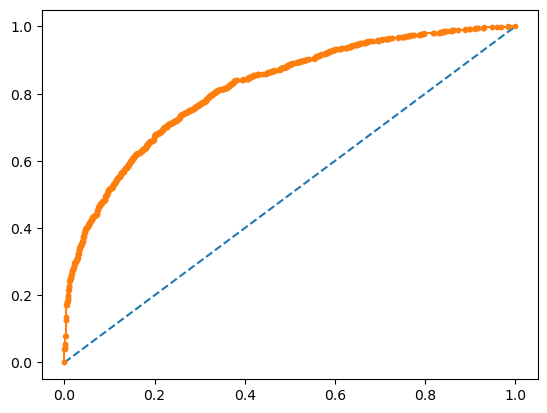

Fim: XGBoost, Undersampling Mean
Início: XGBoost, Undersampling Median
train time: 0.361s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1371
           1       0.75      0.72      0.74      1396

    accuracy                           0.74      2767
   macro avg       0.74      0.74      0.74      2767
weighted avg       0.74      0.74      0.74      2767



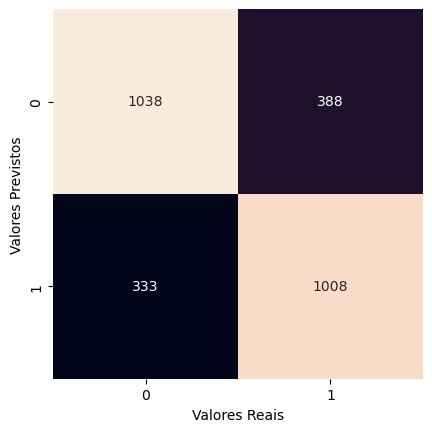

Quant. Transações Bloqueados:  1341 
Sendo 24.832% bloqueadas incorretamente e 75.168% bloqueadas corretamente
AUC: 0.740


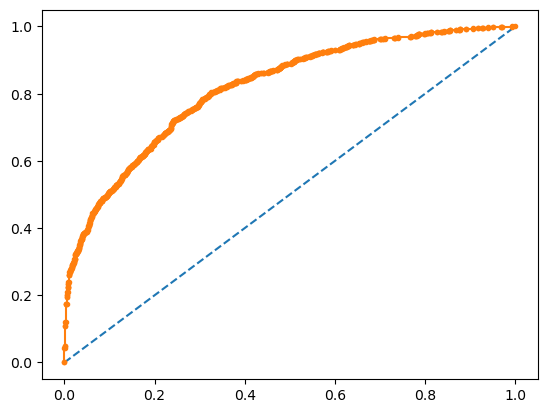

Fim: XGBoost, Undersampling Median
Início: XGBoost, Undersampling Predictions
train time: 0.298s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1371
           1       0.74      0.70      0.72      1396

    accuracy                           0.73      2767
   macro avg       0.73      0.73      0.73      2767
weighted avg       0.73      0.73      0.73      2767



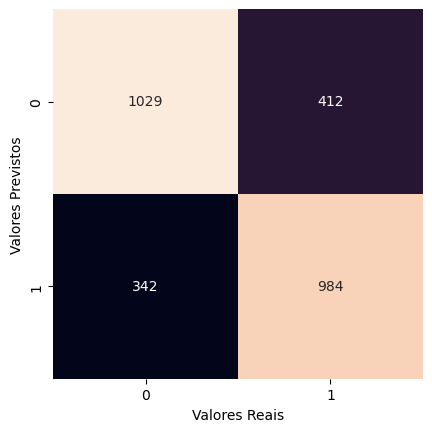

Quant. Transações Bloqueados:  1326 
Sendo 25.792% bloqueadas incorretamente e 74.208% bloqueadas corretamente
AUC: 0.728


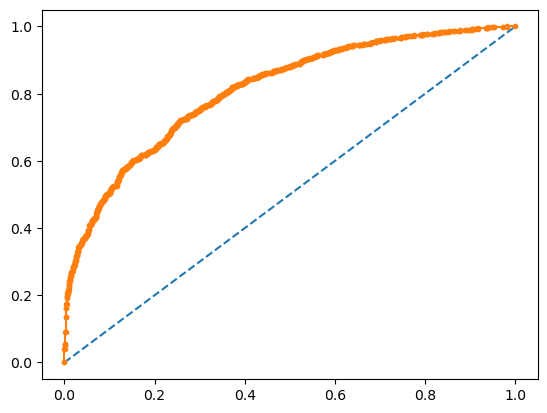

Fim: XGBoost, Undersampling Predictions
Início: XGBoost, Oversampling Missing
train time: 0.706s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3678
           1       0.86      0.79      0.82      3684

    accuracy                           0.83      7362
   macro avg       0.83      0.83      0.83      7362
weighted avg       0.83      0.83      0.83      7362



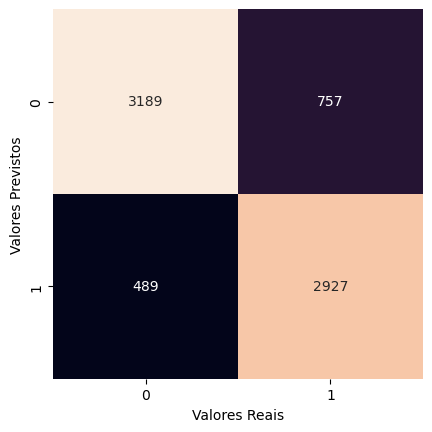

Quant. Transações Bloqueados:  3416 
Sendo 14.315% bloqueadas incorretamente e 85.685% bloqueadas corretamente
AUC: 0.831


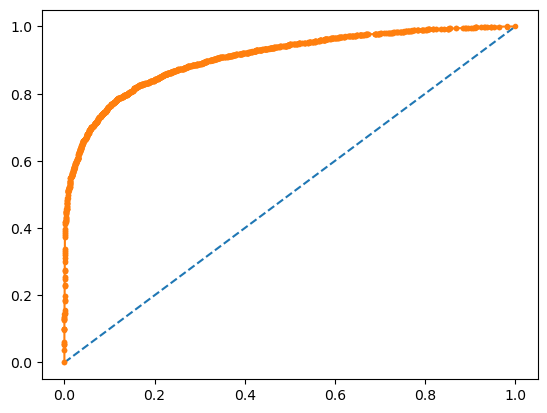

Fim: XGBoost, Oversampling Missing
Início: XGBoost, Oversampling Mean
train time: 0.769s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3678
           1       0.84      0.81      0.83      3684

    accuracy                           0.83      7362
   macro avg       0.83      0.83      0.83      7362
weighted avg       0.83      0.83      0.83      7362



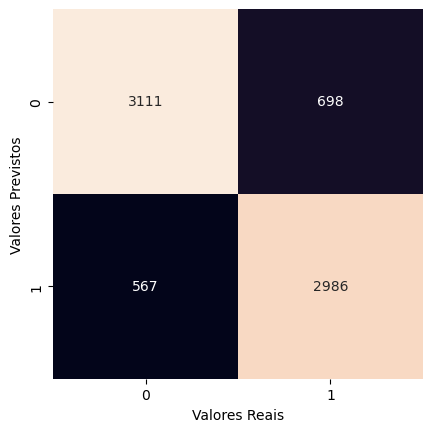

Quant. Transações Bloqueados:  3553 
Sendo 15.958% bloqueadas incorretamente e 84.042% bloqueadas corretamente
AUC: 0.828


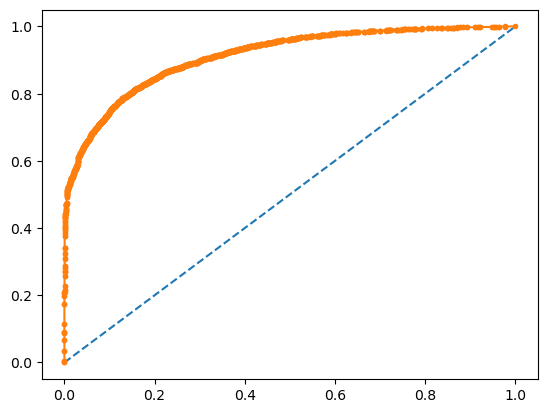

Fim: XGBoost, Oversampling Mean
Início: XGBoost, Oversampling Median
train time: 0.722s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      3678
           1       0.84      0.81      0.82      3684

    accuracy                           0.83      7362
   macro avg       0.83      0.83      0.83      7362
weighted avg       0.83      0.83      0.83      7362



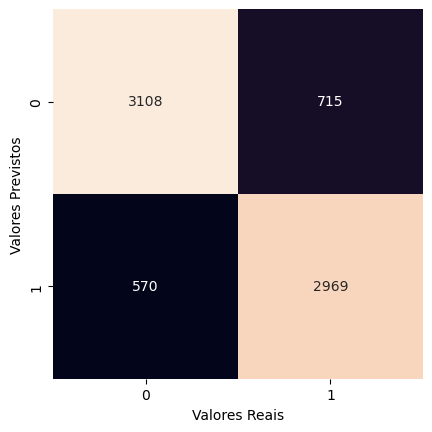

Quant. Transações Bloqueados:  3539 
Sendo 16.106% bloqueadas incorretamente e 83.894% bloqueadas corretamente
AUC: 0.825


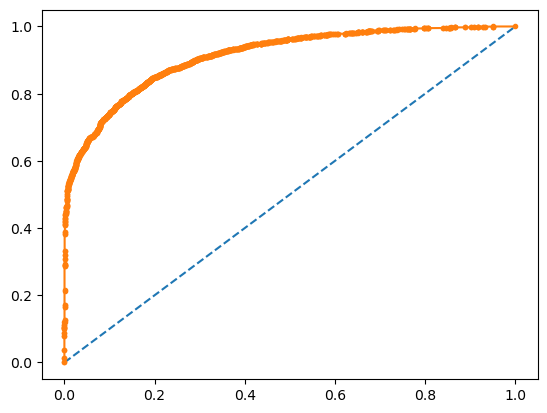

Fim: XGBoost, Oversampling Median
Início: XGBoost, Oversampling Predictions
train time: 0.758s
test time:  0.011s
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      3678
           1       0.84      0.80      0.82      3684

    accuracy                           0.82      7362
   macro avg       0.83      0.82      0.82      7362
weighted avg       0.83      0.82      0.82      7362



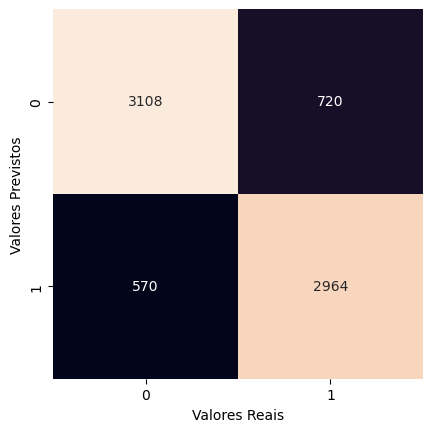

Quant. Transações Bloqueados:  3534 
Sendo 16.129% bloqueadas incorretamente e 83.871% bloqueadas corretamente
AUC: 0.825


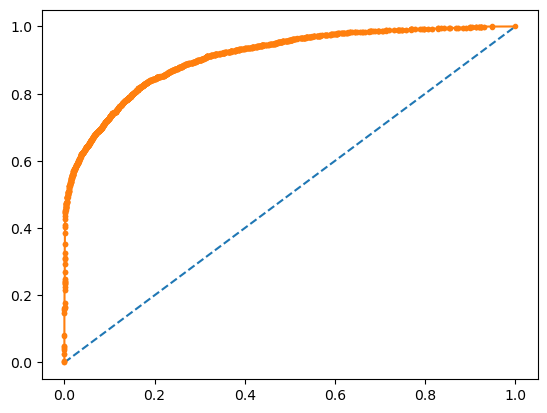

Fim: XGBoost, Oversampling Predictions
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Início: LGBM, Original Missing
train time: 0.110s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3662
           1       0.73      0.44      0.55      1402

    accuracy                           0.80      5064
   macro avg       0.77      0.69      0.71      5064
weighted avg       0.79      0.80      0.78      5064



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


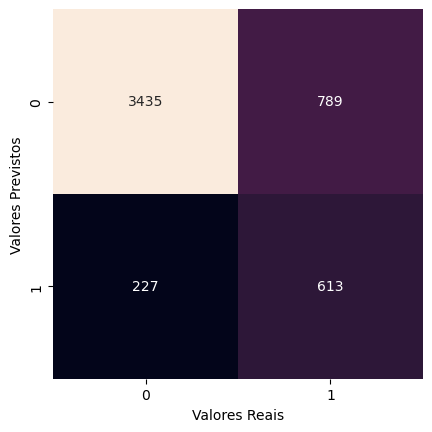

Quant. Transações Bloqueados:  840 
Sendo 27.024% bloqueadas incorretamente e 72.976% bloqueadas corretamente
AUC: 0.688


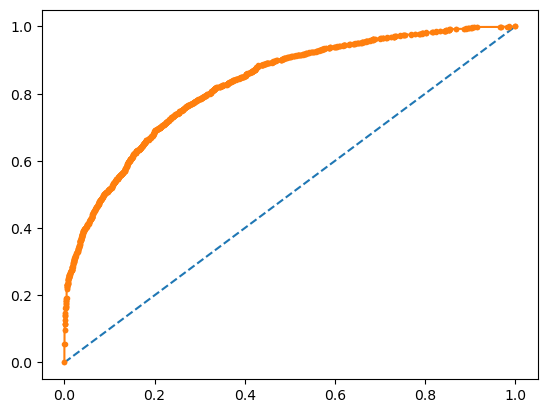

Fim: LGBM, Original Missing
Início: LGBM, Original Mean
train time: 0.094s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3662
           1       0.75      0.45      0.56      1402

    accuracy                           0.81      5064
   macro avg       0.78      0.70      0.72      5064
weighted avg       0.80      0.81      0.79      5064



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


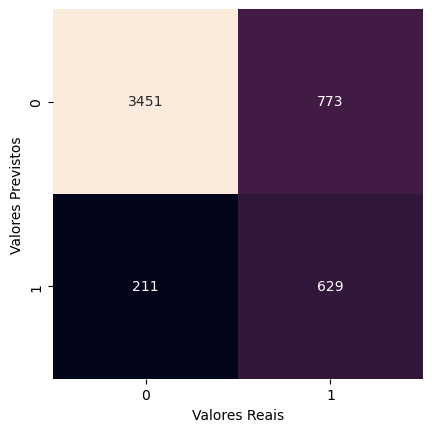

Quant. Transações Bloqueados:  840 
Sendo 25.119% bloqueadas incorretamente e 74.881% bloqueadas corretamente
AUC: 0.696


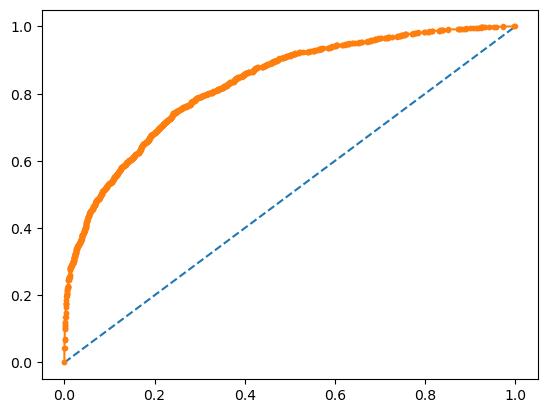

Fim: LGBM, Original Mean
Início: LGBM, Original Median
train time: 0.094s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3662
           1       0.74      0.43      0.55      1402

    accuracy                           0.80      5064
   macro avg       0.78      0.69      0.71      5064
weighted avg       0.79      0.80      0.78      5064



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


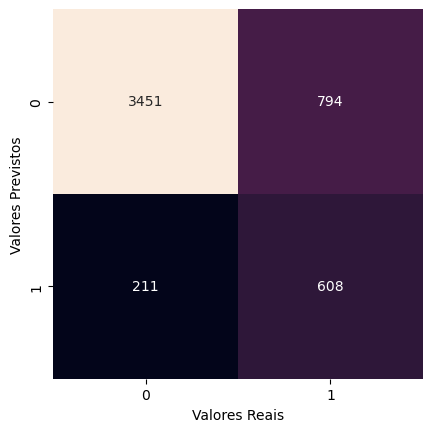

Quant. Transações Bloqueados:  819 
Sendo 25.763% bloqueadas incorretamente e 74.237% bloqueadas corretamente
AUC: 0.688


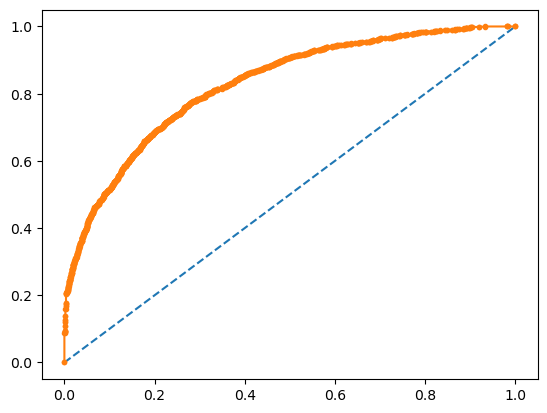

Fim: LGBM, Original Median
Início: LGBM, Original Predictions
train time: 0.094s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3662
           1       0.74      0.42      0.54      1402

    accuracy                           0.80      5064
   macro avg       0.78      0.68      0.71      5064
weighted avg       0.79      0.80      0.78      5064



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


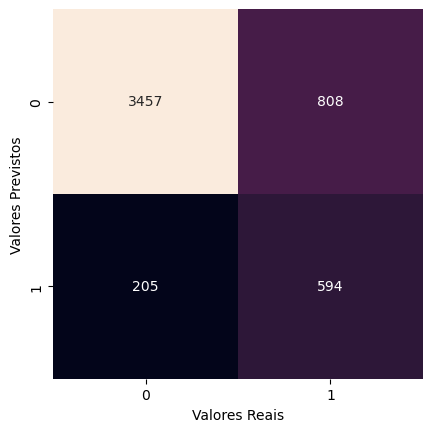

Quant. Transações Bloqueados:  799 
Sendo 25.657% bloqueadas incorretamente e 74.343% bloqueadas corretamente
AUC: 0.684


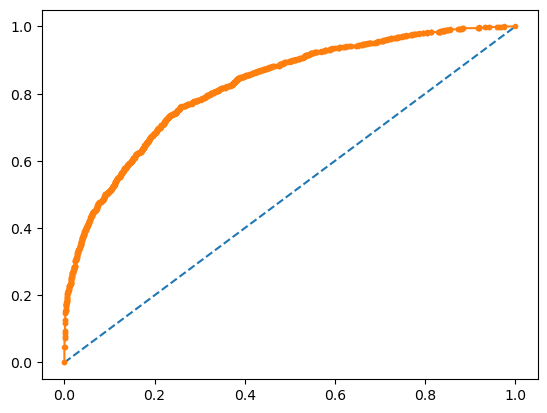

Fim: LGBM, Original Predictions
Início: LGBM, Undersampling Missing
train time: 0.094s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1371
           1       0.75      0.72      0.74      1396

    accuracy                           0.74      2767
   macro avg       0.74      0.74      0.74      2767
weighted avg       0.74      0.74      0.74      2767



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


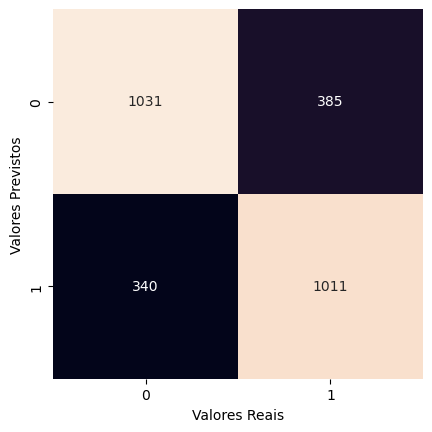

Quant. Transações Bloqueados:  1351 
Sendo 25.167% bloqueadas incorretamente e 74.833% bloqueadas corretamente
AUC: 0.738


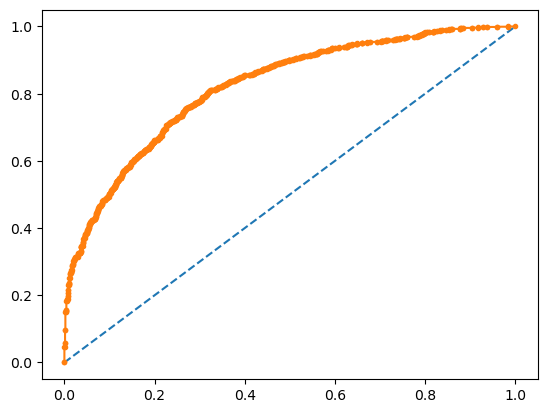

Fim: LGBM, Undersampling Missing
Início: LGBM, Undersampling Mean
train time: 0.094s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1371
           1       0.74      0.72      0.73      1396

    accuracy                           0.73      2767
   macro avg       0.73      0.73      0.73      2767
weighted avg       0.73      0.73      0.73      2767



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


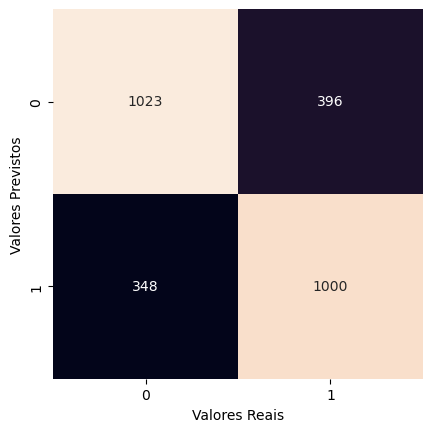

Quant. Transações Bloqueados:  1348 
Sendo 25.816% bloqueadas incorretamente e 74.184% bloqueadas corretamente
AUC: 0.731


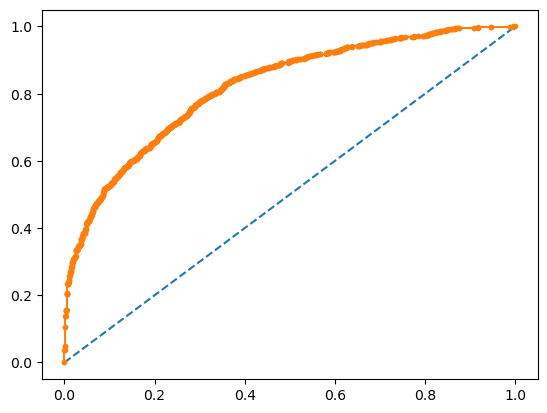

Fim: LGBM, Undersampling Mean
Início: LGBM, Undersampling Median
train time: 0.079s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1371
           1       0.75      0.73      0.74      1396

    accuracy                           0.74      2767
   macro avg       0.74      0.74      0.74      2767
weighted avg       0.74      0.74      0.74      2767



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


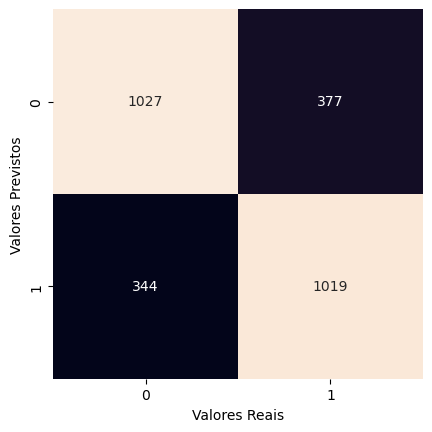

Quant. Transações Bloqueados:  1363 
Sendo 25.238% bloqueadas incorretamente e 74.762% bloqueadas corretamente
AUC: 0.740


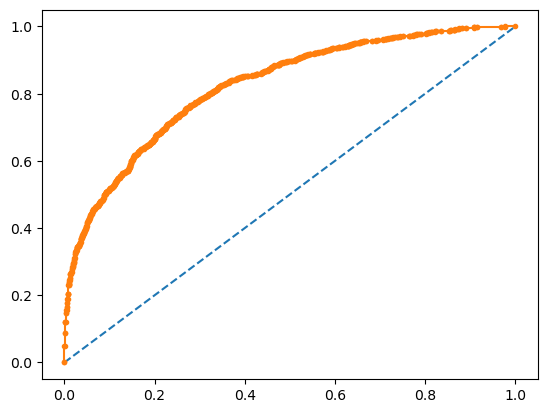

Fim: LGBM, Undersampling Median
Início: LGBM, Undersampling Predictions
train time: 0.094s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1371
           1       0.74      0.73      0.73      1396

    accuracy                           0.73      2767
   macro avg       0.73      0.73      0.73      2767
weighted avg       0.73      0.73      0.73      2767



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


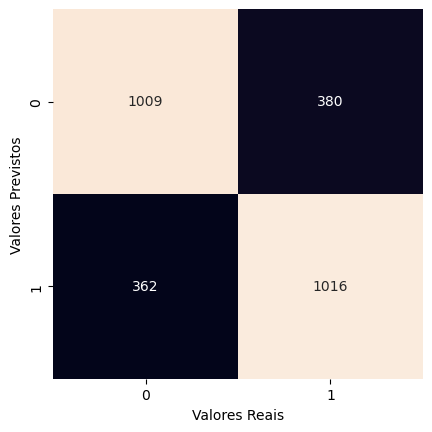

Quant. Transações Bloqueados:  1378 
Sendo 26.270% bloqueadas incorretamente e 73.730% bloqueadas corretamente
AUC: 0.732


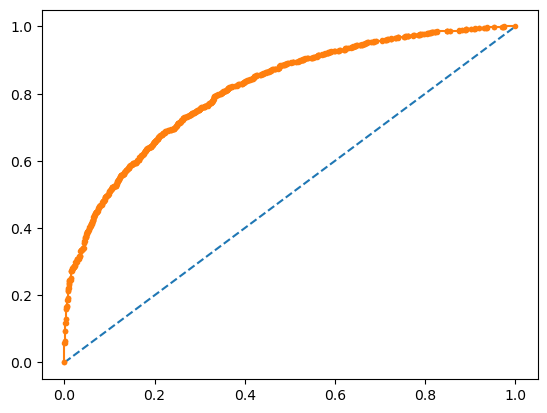

Fim: LGBM, Undersampling Predictions
Início: LGBM, Oversampling Missing
train time: 0.141s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      3678
           1       0.86      0.79      0.82      3684

    accuracy                           0.83      7362
   macro avg       0.83      0.83      0.83      7362
weighted avg       0.83      0.83      0.83      7362



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


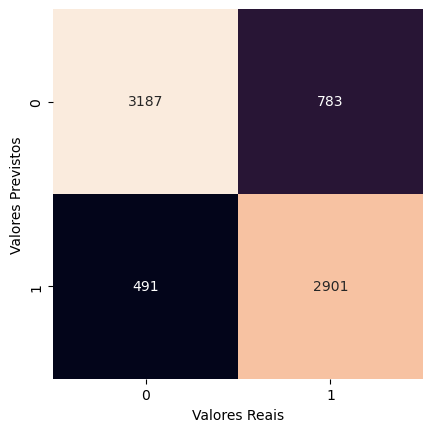

Quant. Transações Bloqueados:  3392 
Sendo 14.475% bloqueadas incorretamente e 85.525% bloqueadas corretamente
AUC: 0.827


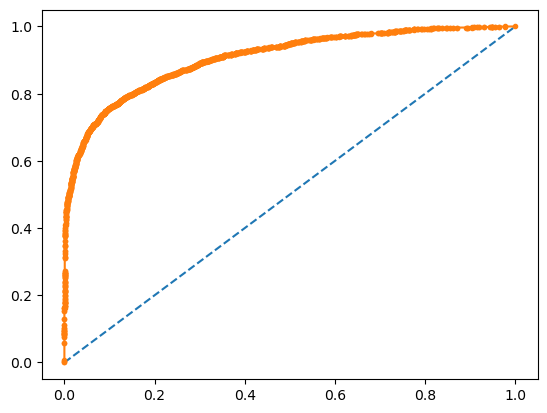

Fim: LGBM, Oversampling Missing
Início: LGBM, Oversampling Mean
train time: 0.125s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3678
           1       0.83      0.80      0.81      3684

    accuracy                           0.82      7362
   macro avg       0.82      0.82      0.82      7362
weighted avg       0.82      0.82      0.82      7362



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


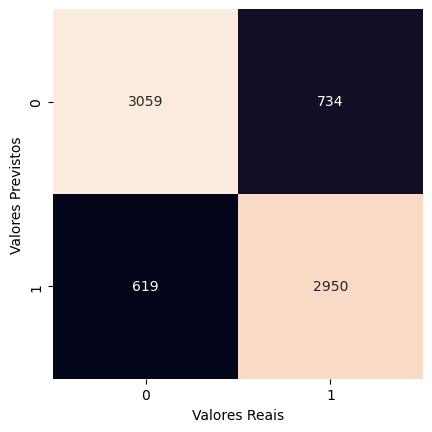

Quant. Transações Bloqueados:  3569 
Sendo 17.344% bloqueadas incorretamente e 82.656% bloqueadas corretamente
AUC: 0.816


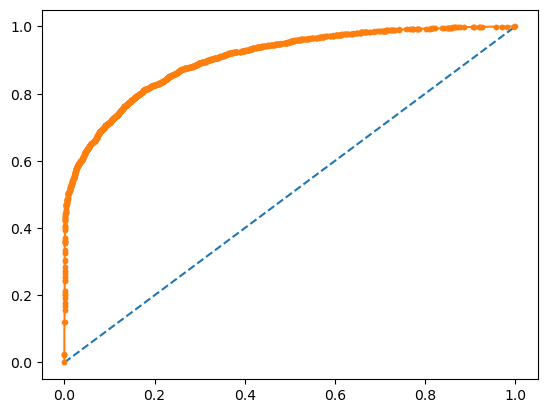

Fim: LGBM, Oversampling Mean
Início: LGBM, Oversampling Median
train time: 0.126s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      3678
           1       0.82      0.80      0.81      3684

    accuracy                           0.81      7362
   macro avg       0.81      0.81      0.81      7362
weighted avg       0.81      0.81      0.81      7362



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


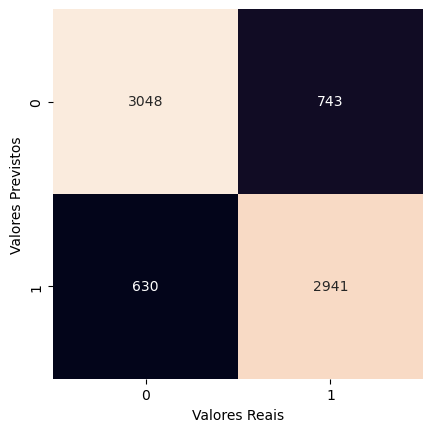

Quant. Transações Bloqueados:  3571 
Sendo 17.642% bloqueadas incorretamente e 82.358% bloqueadas corretamente
AUC: 0.814


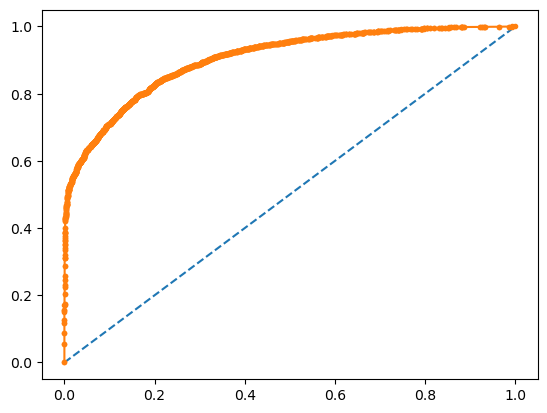

Fim: LGBM, Oversampling Median
Início: LGBM, Oversampling Predictions
train time: 0.141s
test time:  0.016s
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      3678
           1       0.83      0.80      0.81      3684

    accuracy                           0.81      7362
   macro avg       0.81      0.81      0.81      7362
weighted avg       0.81      0.81      0.81      7362



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


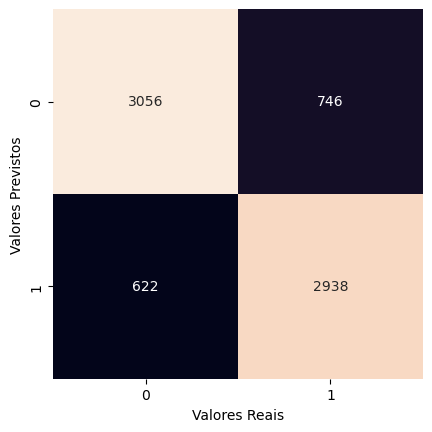

Quant. Transações Bloqueados:  3560 
Sendo 17.472% bloqueadas incorretamente e 82.528% bloqueadas corretamente
AUC: 0.814


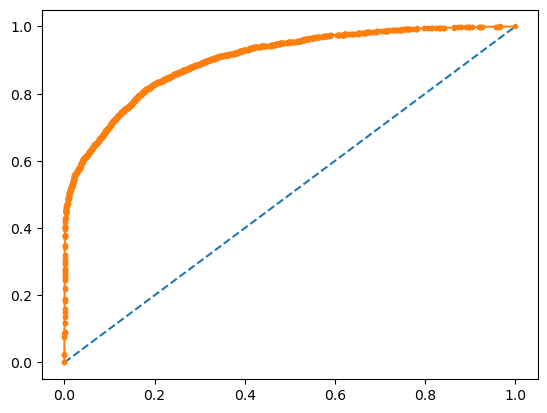

Fim: LGBM, Oversampling Predictions
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Início: Random Forest, Original Mean


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.273s
test time:  0.077s
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3662
           1       0.71      0.42      0.53      1402

    accuracy                           0.79      5064
   macro avg       0.76      0.68      0.70      5064
weighted avg       0.78      0.79      0.77      5064



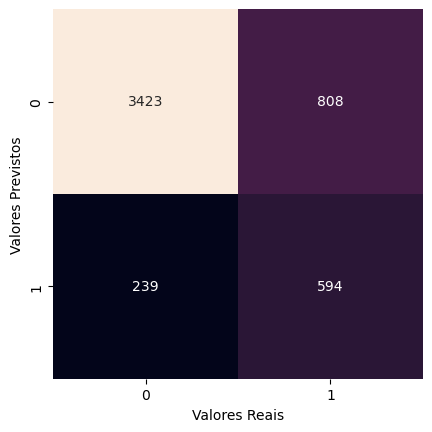

Quant. Transações Bloqueados:  833 
Sendo 28.691% bloqueadas incorretamente e 71.309% bloqueadas corretamente
AUC: 0.679


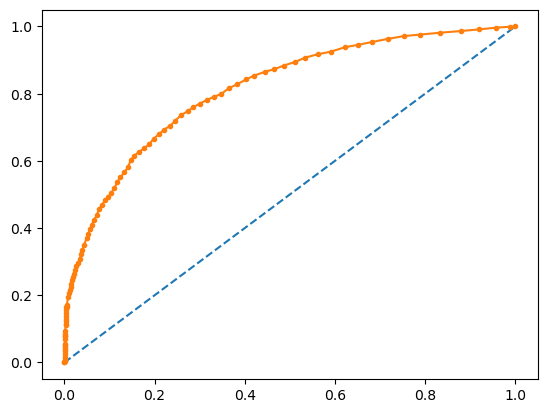

Fim: Random Forest, Original Mean
Início: Random Forest, Original Median


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.239s
test time:  0.079s
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3662
           1       0.70      0.42      0.53      1402

    accuracy                           0.79      5064
   macro avg       0.76      0.68      0.70      5064
weighted avg       0.78      0.79      0.77      5064



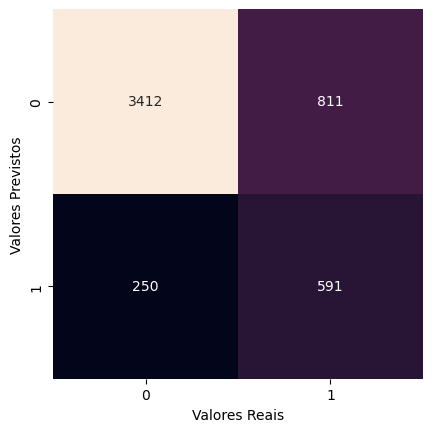

Quant. Transações Bloqueados:  841 
Sendo 29.727% bloqueadas incorretamente e 70.273% bloqueadas corretamente
AUC: 0.677


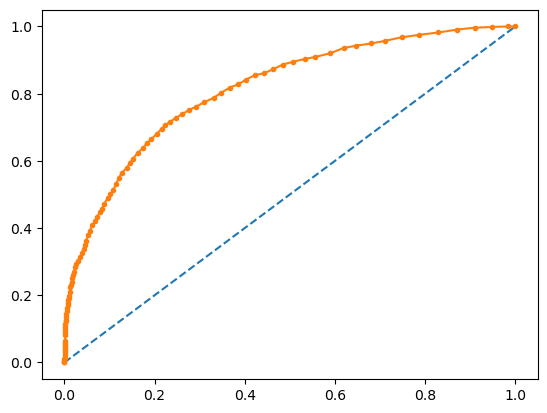

Fim: Random Forest, Original Median
Início: Random Forest, Original Predictions


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.366s
test time:  0.094s
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3662
           1       0.70      0.41      0.52      1402

    accuracy                           0.79      5064
   macro avg       0.75      0.67      0.69      5064
weighted avg       0.78      0.79      0.77      5064



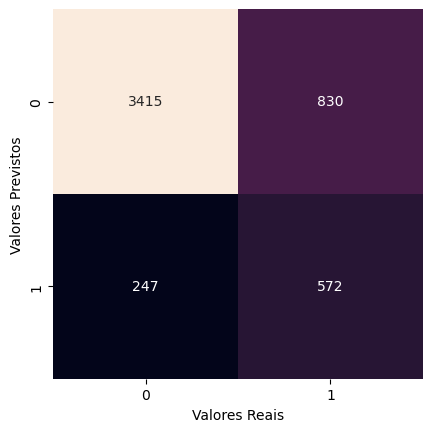

Quant. Transações Bloqueados:  819 
Sendo 30.159% bloqueadas incorretamente e 69.841% bloqueadas corretamente
AUC: 0.670


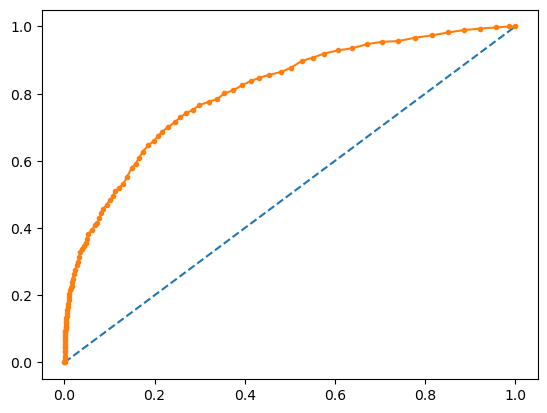

Fim: Random Forest, Original Predictions
Início: Random Forest, Undersampling Mean


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 0.721s
test time:  0.047s
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1371
           1       0.74      0.73      0.73      1396

    accuracy                           0.73      2767
   macro avg       0.73      0.73      0.73      2767
weighted avg       0.73      0.73      0.73      2767



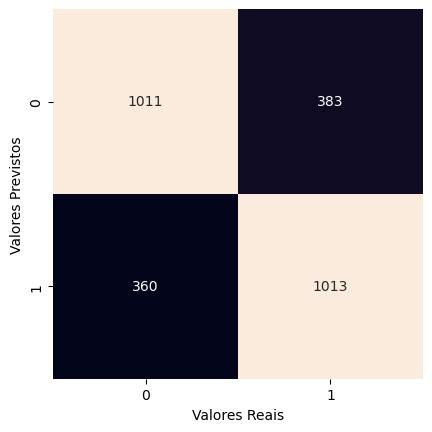

Quant. Transações Bloqueados:  1373 
Sendo 26.220% bloqueadas incorretamente e 73.780% bloqueadas corretamente
AUC: 0.732


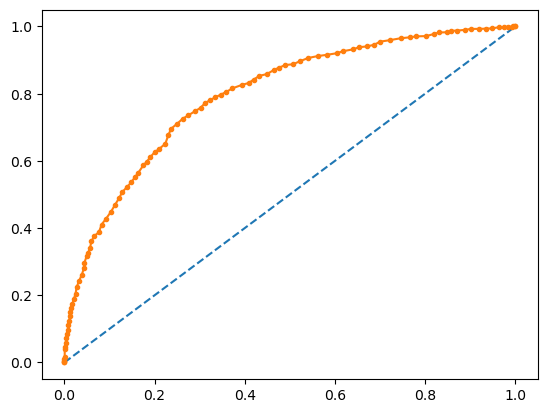

Fim: Random Forest, Undersampling Mean
Início: Random Forest, Undersampling Median


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 0.770s
test time:  0.062s
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1371
           1       0.74      0.72      0.73      1396

    accuracy                           0.73      2767
   macro avg       0.73      0.73      0.73      2767
weighted avg       0.73      0.73      0.73      2767



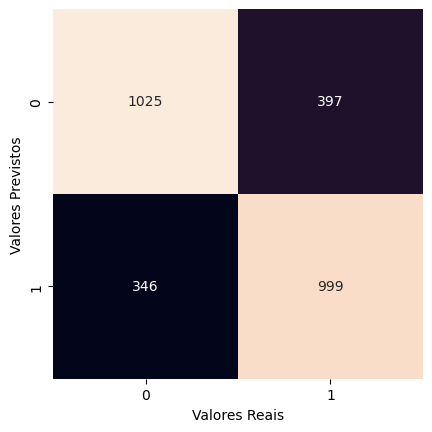

Quant. Transações Bloqueados:  1345 
Sendo 25.725% bloqueadas incorretamente e 74.275% bloqueadas corretamente
AUC: 0.732


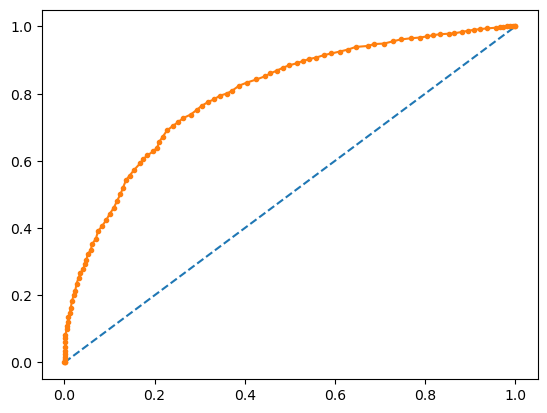

Fim: Random Forest, Undersampling Median
Início: Random Forest, Undersampling Predictions


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 0.738s
test time:  0.063s
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1371
           1       0.74      0.72      0.73      1396

    accuracy                           0.73      2767
   macro avg       0.73      0.73      0.73      2767
weighted avg       0.73      0.73      0.73      2767



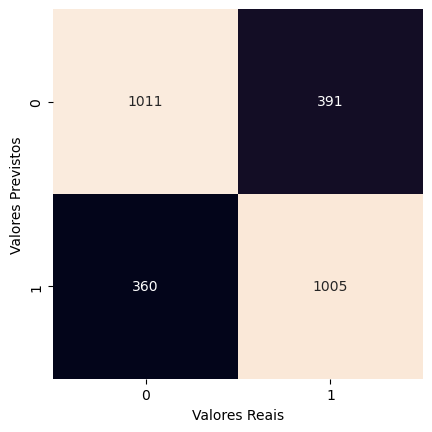

Quant. Transações Bloqueados:  1365 
Sendo 26.374% bloqueadas incorretamente e 73.626% bloqueadas corretamente
AUC: 0.729


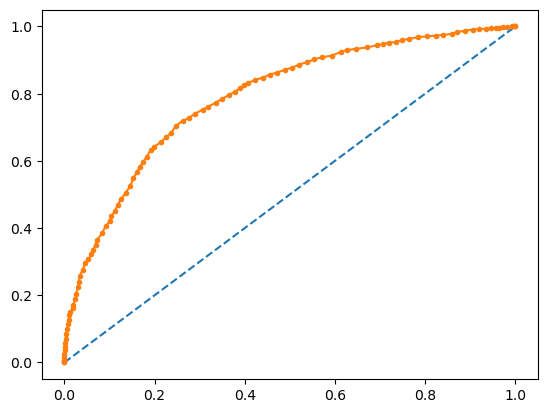

Fim: Random Forest, Undersampling Predictions
Início: Random Forest, Oversampling Mean


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.874s
test time:  0.119s
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3678
           1       0.82      0.81      0.81      3684

    accuracy                           0.81      7362
   macro avg       0.81      0.81      0.81      7362
weighted avg       0.81      0.81      0.81      7362



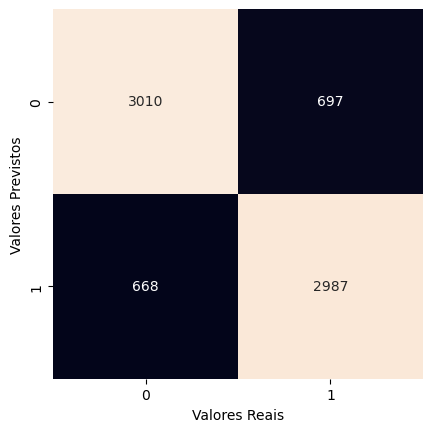

Quant. Transações Bloqueados:  3655 
Sendo 18.276% bloqueadas incorretamente e 81.724% bloqueadas corretamente
AUC: 0.815


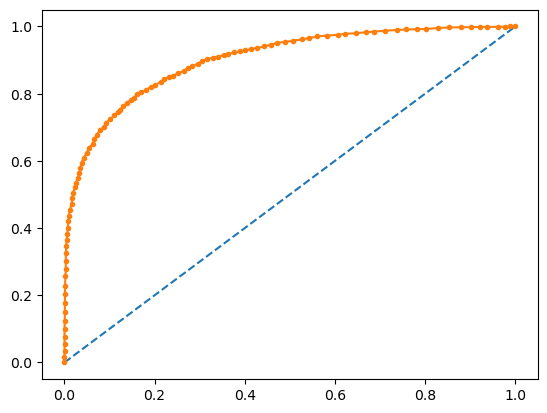

Fim: Random Forest, Oversampling Mean
Início: Random Forest, Oversampling Median


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.790s
test time:  0.141s
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3678
           1       0.82      0.82      0.82      3684

    accuracy                           0.82      7362
   macro avg       0.82      0.82      0.82      7362
weighted avg       0.82      0.82      0.82      7362



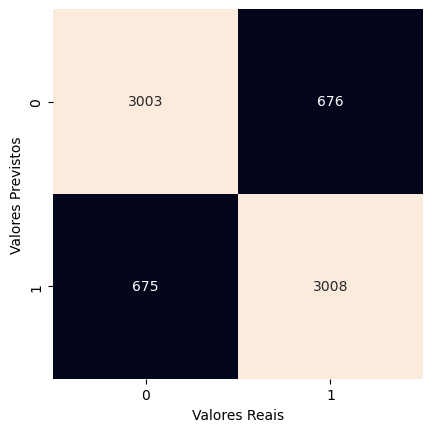

Quant. Transações Bloqueados:  3683 
Sendo 18.327% bloqueadas incorretamente e 81.673% bloqueadas corretamente
AUC: 0.816


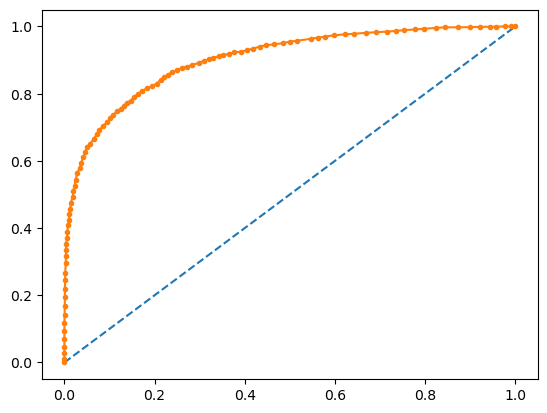

Fim: Random Forest, Oversampling Median
Início: Random Forest, Oversampling Predictions


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.882s
test time:  0.126s
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3678
           1       0.82      0.81      0.81      3684

    accuracy                           0.82      7362
   macro avg       0.82      0.82      0.82      7362
weighted avg       0.82      0.82      0.82      7362



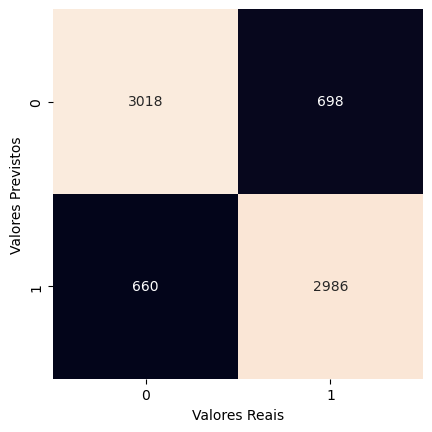

Quant. Transações Bloqueados:  3646 
Sendo 18.102% bloqueadas incorretamente e 81.898% bloqueadas corretamente
AUC: 0.816


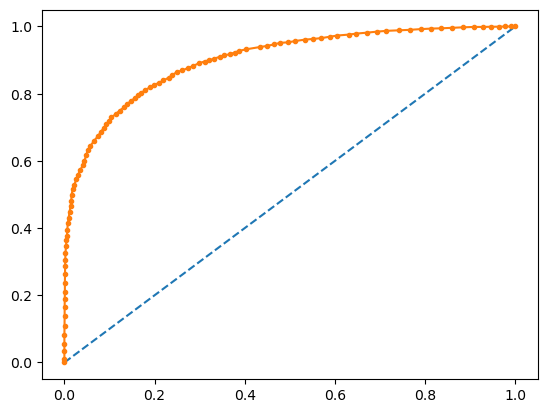

Fim: Random Forest, Oversampling Predictions
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Início: Decision Tree, Original Mean
train time: 0.079s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3662
           1       0.49      0.49      0.49      1402

    accuracy                           0.72      5064
   macro avg       0.65      0.65      0.65      5064
weighted avg       0.72      0.72      0.72      5064



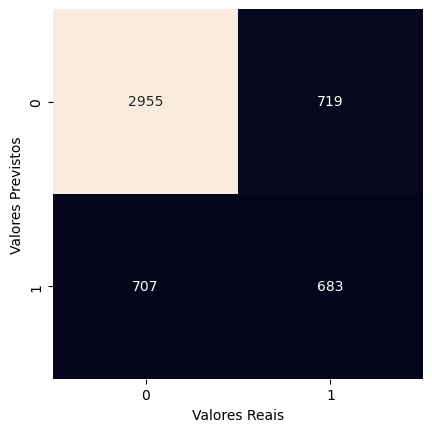

Quant. Transações Bloqueados:  1390 
Sendo 50.863% bloqueadas incorretamente e 49.137% bloqueadas corretamente
AUC: 0.647


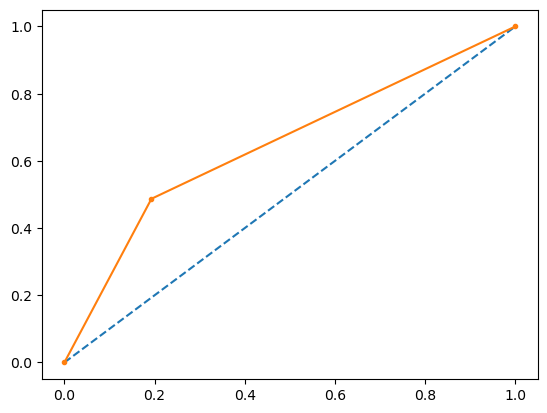

Fim: Decision Tree, Original Mean
Início: Decision Tree, Original Median
train time: 0.077s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      3662
           1       0.50      0.52      0.51      1402

    accuracy                           0.72      5064
   macro avg       0.66      0.66      0.66      5064
weighted avg       0.73      0.72      0.73      5064



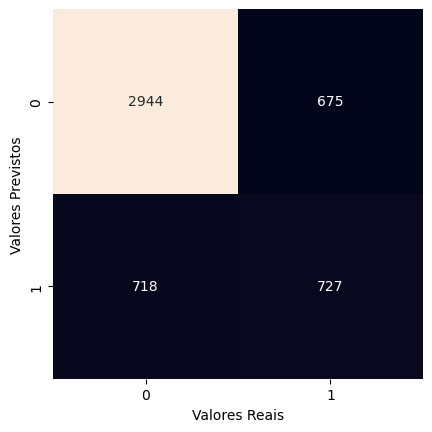

Quant. Transações Bloqueados:  1445 
Sendo 49.689% bloqueadas incorretamente e 50.311% bloqueadas corretamente
AUC: 0.661


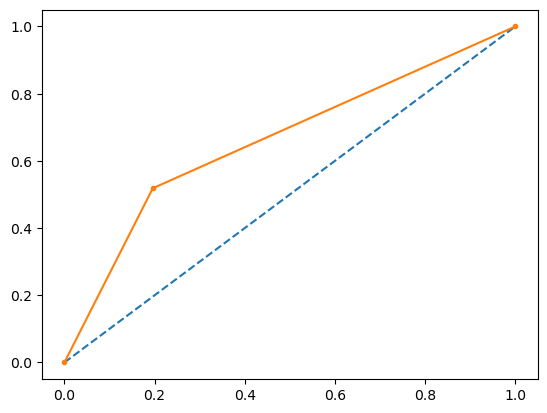

Fim: Decision Tree, Original Median
Início: Decision Tree, Original Predictions
train time: 0.063s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3662
           1       0.49      0.52      0.50      1402

    accuracy                           0.72      5064
   macro avg       0.65      0.65      0.65      5064
weighted avg       0.72      0.72      0.72      5064



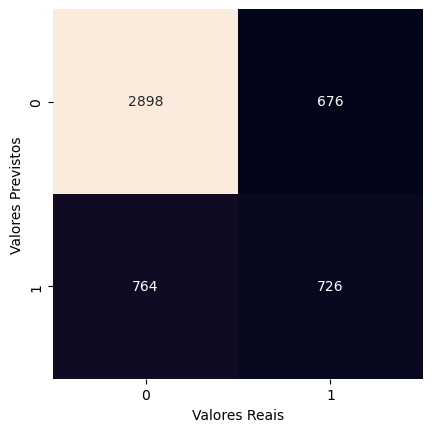

Quant. Transações Bloqueados:  1490 
Sendo 51.275% bloqueadas incorretamente e 48.725% bloqueadas corretamente
AUC: 0.655


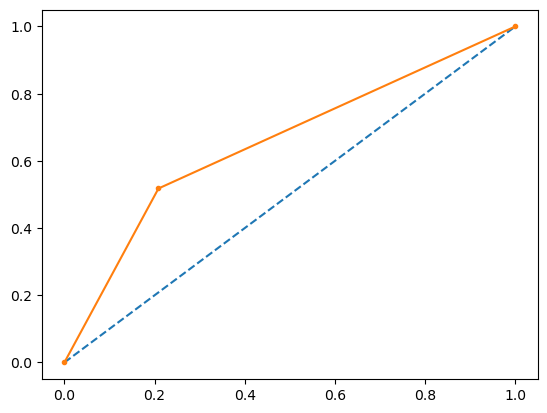

Fim: Decision Tree, Original Predictions
Início: Decision Tree, Undersampling Mean
train time: 0.047s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1371
           1       0.65      0.61      0.63      1396

    accuracy                           0.64      2767
   macro avg       0.64      0.64      0.64      2767
weighted avg       0.64      0.64      0.64      2767



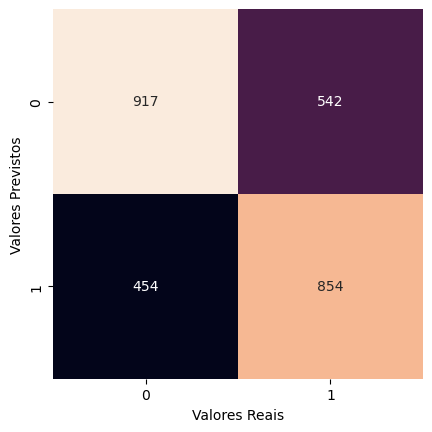

Quant. Transações Bloqueados:  1308 
Sendo 34.709% bloqueadas incorretamente e 65.291% bloqueadas corretamente
AUC: 0.640


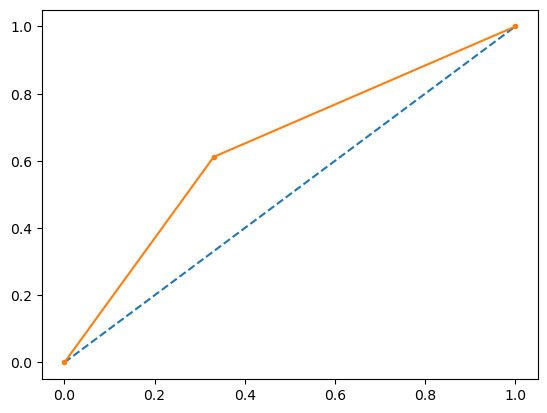

Fim: Decision Tree, Undersampling Mean
Início: Decision Tree, Undersampling Median
train time: 0.031s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1371
           1       0.65      0.63      0.64      1396

    accuracy                           0.64      2767
   macro avg       0.64      0.64      0.64      2767
weighted avg       0.64      0.64      0.64      2767



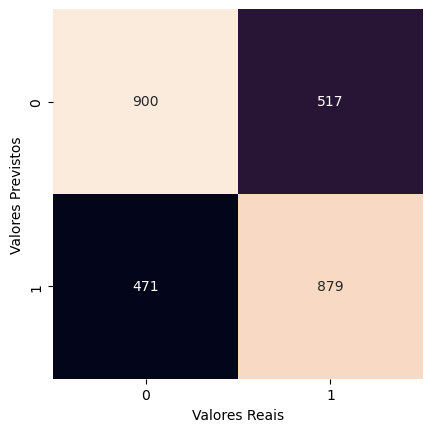

Quant. Transações Bloqueados:  1350 
Sendo 34.889% bloqueadas incorretamente e 65.111% bloqueadas corretamente
AUC: 0.643


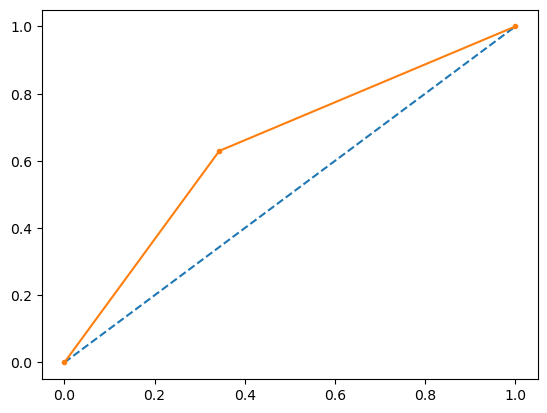

Fim: Decision Tree, Undersampling Median
Início: Decision Tree, Undersampling Predictions
train time: 0.047s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1371
           1       0.65      0.64      0.64      1396

    accuracy                           0.64      2767
   macro avg       0.64      0.64      0.64      2767
weighted avg       0.64      0.64      0.64      2767



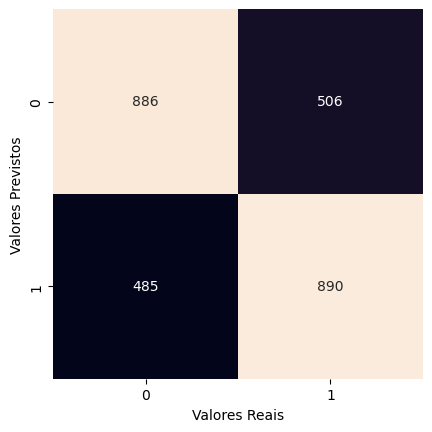

Quant. Transações Bloqueados:  1375 
Sendo 35.273% bloqueadas incorretamente e 64.727% bloqueadas corretamente
AUC: 0.642


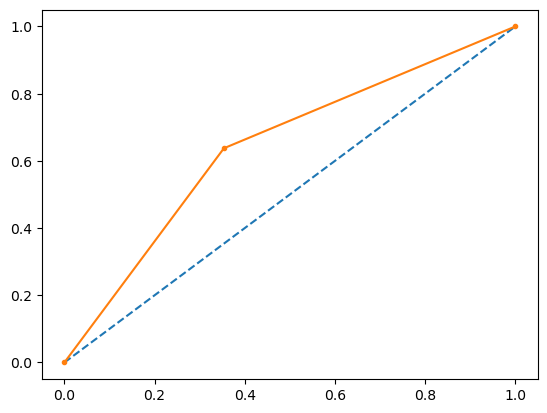

Fim: Decision Tree, Undersampling Predictions
Início: Decision Tree, Oversampling Mean
train time: 0.089s
test time:  0.012s
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3678
           1       0.74      0.77      0.75      3684

    accuracy                           0.75      7362
   macro avg       0.75      0.75      0.75      7362
weighted avg       0.75      0.75      0.75      7362



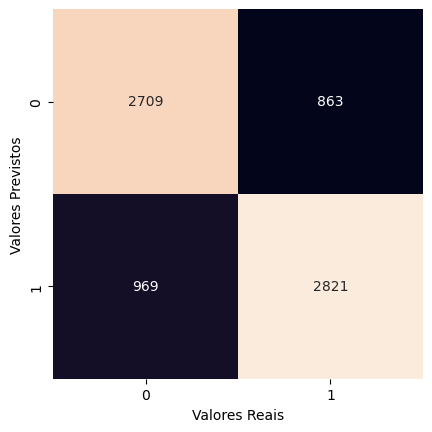

Quant. Transações Bloqueados:  3790 
Sendo 25.567% bloqueadas incorretamente e 74.433% bloqueadas corretamente
AUC: 0.751


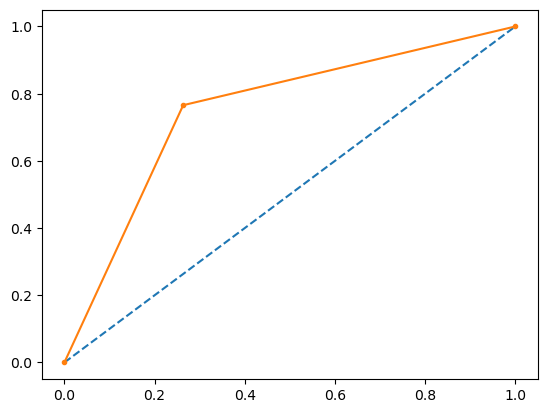

Fim: Decision Tree, Oversampling Mean
Início: Decision Tree, Oversampling Median
train time: 0.094s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      3678
           1       0.75      0.77      0.76      3684

    accuracy                           0.76      7362
   macro avg       0.76      0.76      0.76      7362
weighted avg       0.76      0.76      0.76      7362



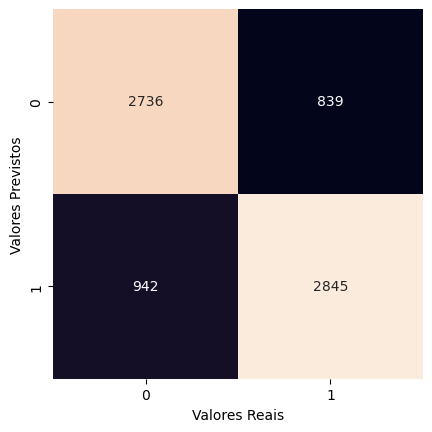

Quant. Transações Bloqueados:  3787 
Sendo 24.875% bloqueadas incorretamente e 75.125% bloqueadas corretamente
AUC: 0.758


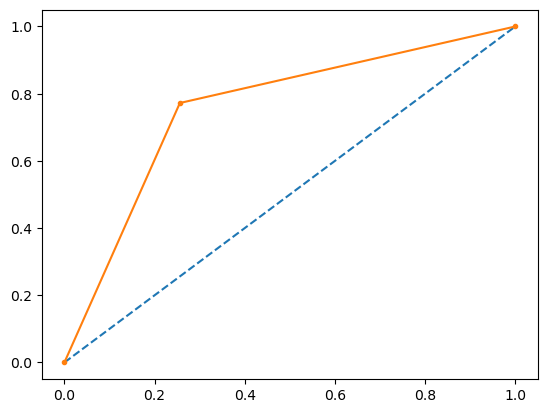

Fim: Decision Tree, Oversampling Median
Início: Decision Tree, Oversampling Predictions
train time: 0.094s
test time:  0.000s
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      3678
           1       0.74      0.76      0.75      3684

    accuracy                           0.75      7362
   macro avg       0.75      0.75      0.75      7362
weighted avg       0.75      0.75      0.75      7362



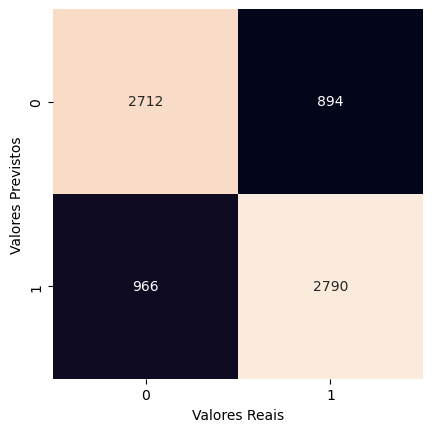

Quant. Transações Bloqueados:  3756 
Sendo 25.719% bloqueadas incorretamente e 74.281% bloqueadas corretamente
AUC: 0.747


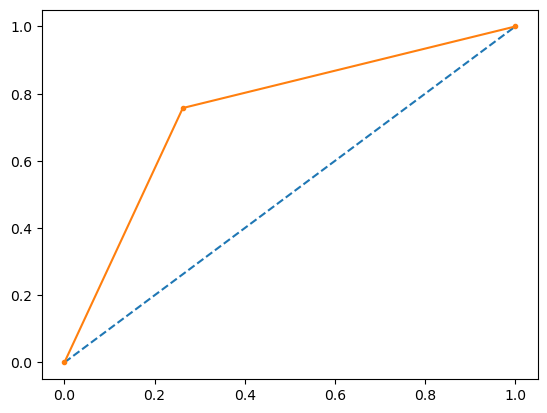

Fim: Decision Tree, Oversampling Predictions
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Início: Extra Trees, Original Mean


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 0.988s
test time:  0.110s
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3662
           1       0.67      0.43      0.53      1402

    accuracy                           0.78      5064
   macro avg       0.74      0.68      0.69      5064
weighted avg       0.77      0.78      0.77      5064



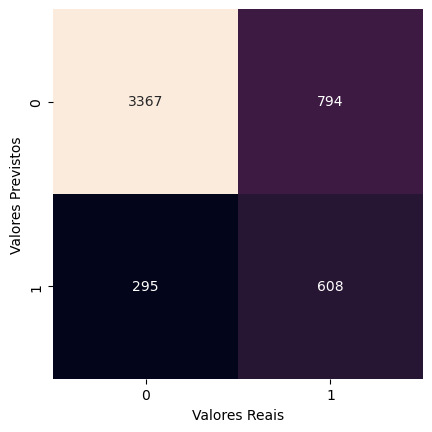

Quant. Transações Bloqueados:  903 
Sendo 32.669% bloqueadas incorretamente e 67.331% bloqueadas corretamente
AUC: 0.677


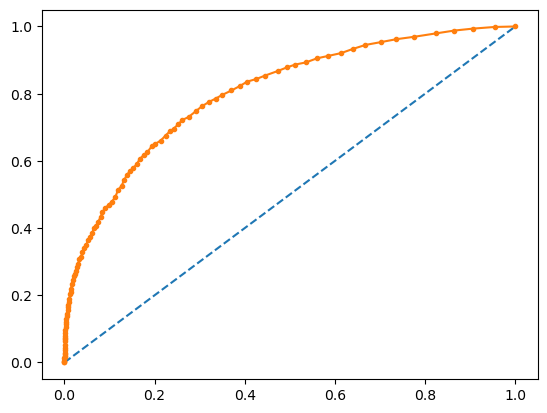

Fim: Extra Trees, Original Mean
Início: Extra Trees, Original Median


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.036s
test time:  0.110s
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3662
           1       0.66      0.42      0.52      1402

    accuracy                           0.78      5064
   macro avg       0.73      0.67      0.69      5064
weighted avg       0.77      0.78      0.76      5064



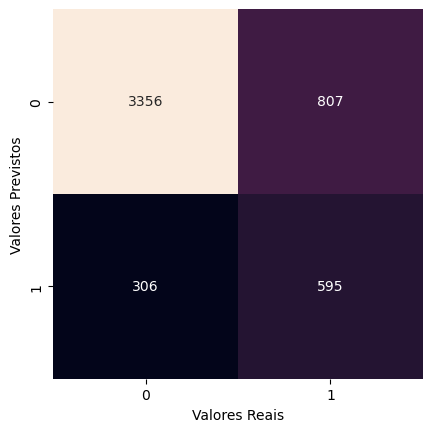

Quant. Transações Bloqueados:  901 
Sendo 33.962% bloqueadas incorretamente e 66.038% bloqueadas corretamente
AUC: 0.670


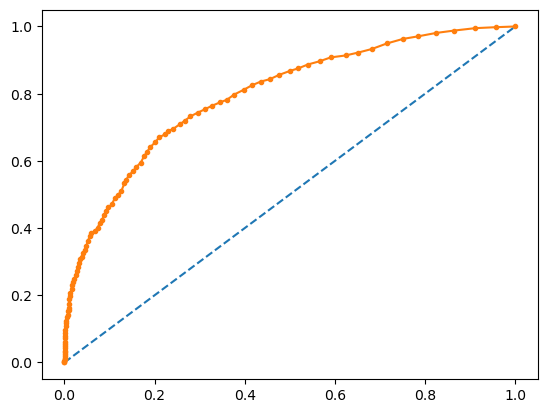

Fim: Extra Trees, Original Median
Início: Extra Trees, Original Predictions


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.020s
test time:  0.113s
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3662
           1       0.67      0.43      0.52      1402

    accuracy                           0.78      5064
   macro avg       0.74      0.67      0.69      5064
weighted avg       0.77      0.78      0.77      5064



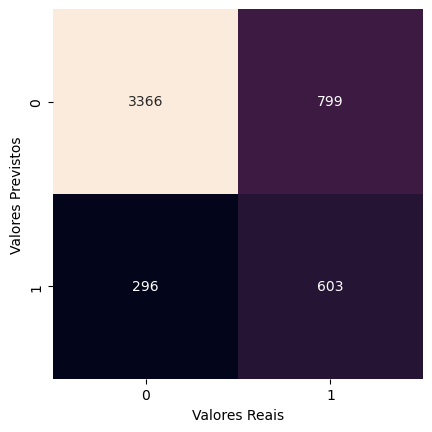

Quant. Transações Bloqueados:  899 
Sendo 32.925% bloqueadas incorretamente e 67.075% bloqueadas corretamente
AUC: 0.675


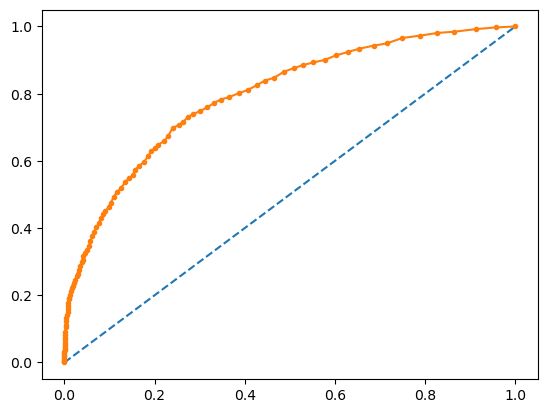

Fim: Extra Trees, Original Predictions
Início: Extra Trees, Undersampling Mean


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 0.581s
test time:  0.063s
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1371
           1       0.72      0.71      0.72      1396

    accuracy                           0.72      2767
   macro avg       0.72      0.72      0.72      2767
weighted avg       0.72      0.72      0.72      2767



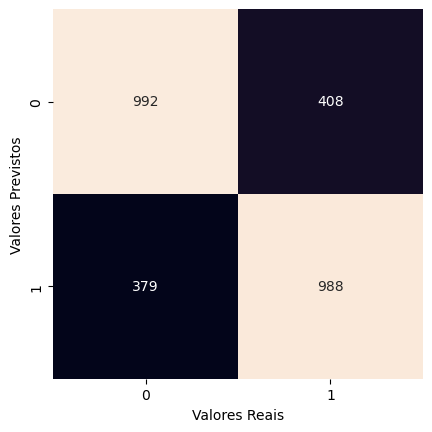

Quant. Transações Bloqueados:  1367 
Sendo 27.725% bloqueadas incorretamente e 72.275% bloqueadas corretamente
AUC: 0.716


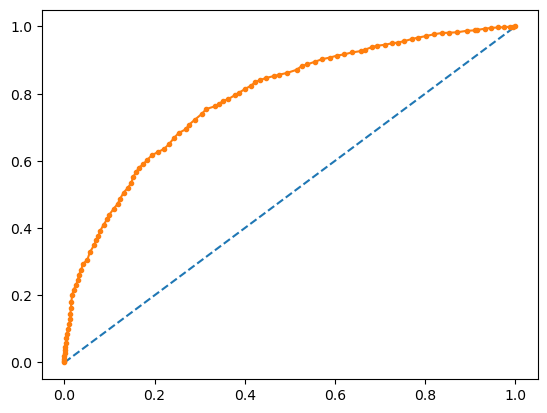

Fim: Extra Trees, Undersampling Mean
Início: Extra Trees, Undersampling Median


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 0.596s
test time:  0.063s
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1371
           1       0.72      0.71      0.72      1396

    accuracy                           0.72      2767
   macro avg       0.72      0.72      0.72      2767
weighted avg       0.72      0.72      0.72      2767



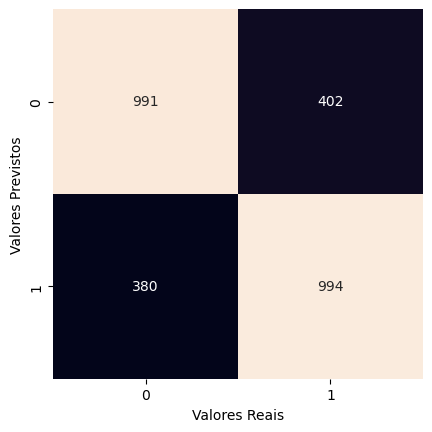

Quant. Transações Bloqueados:  1374 
Sendo 27.656% bloqueadas incorretamente e 72.344% bloqueadas corretamente
AUC: 0.717


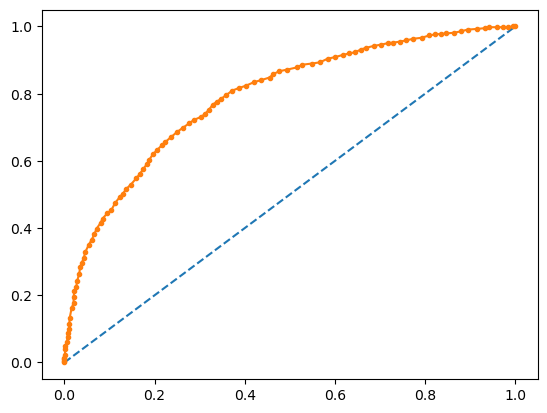

Fim: Extra Trees, Undersampling Median
Início: Extra Trees, Undersampling Predictions


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 0.612s
test time:  0.063s
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1371
           1       0.73      0.71      0.72      1396

    accuracy                           0.72      2767
   macro avg       0.72      0.72      0.72      2767
weighted avg       0.72      0.72      0.72      2767



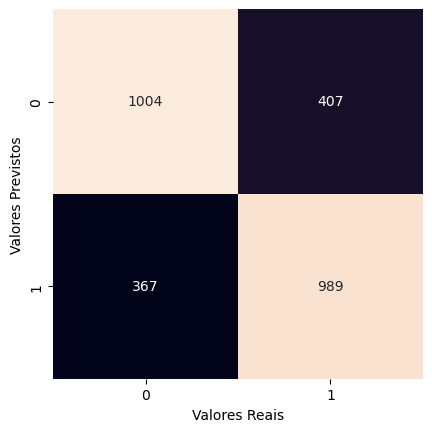

Quant. Transações Bloqueados:  1356 
Sendo 27.065% bloqueadas incorretamente e 72.935% bloqueadas corretamente
AUC: 0.720


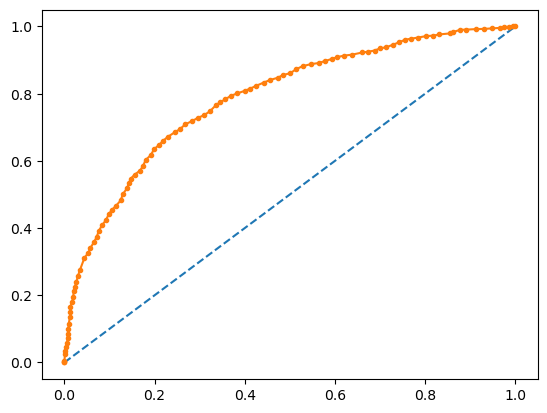

Fim: Extra Trees, Undersampling Predictions
Início: Extra Trees, Oversampling Mean


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.522s
test time:  0.173s
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3678
           1       0.81      0.81      0.81      3684

    accuracy                           0.81      7362
   macro avg       0.81      0.81      0.81      7362
weighted avg       0.81      0.81      0.81      7362



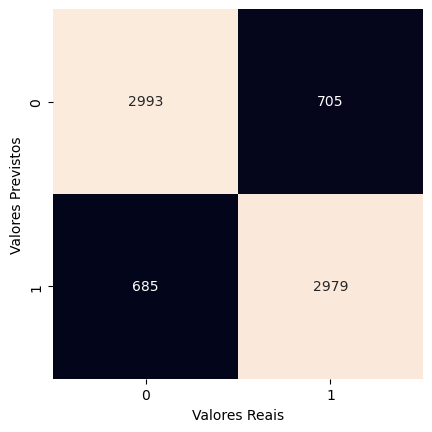

Quant. Transações Bloqueados:  3664 
Sendo 18.695% bloqueadas incorretamente e 81.305% bloqueadas corretamente
AUC: 0.811


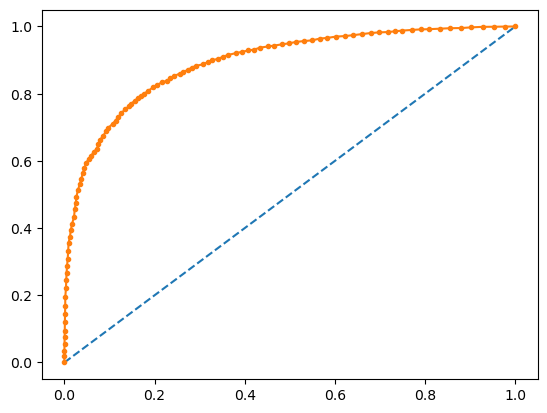

Fim: Extra Trees, Oversampling Mean
Início: Extra Trees, Oversampling Median


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.490s
test time:  0.172s
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3678
           1       0.81      0.80      0.81      3684

    accuracy                           0.81      7362
   macro avg       0.81      0.81      0.81      7362
weighted avg       0.81      0.81      0.81      7362



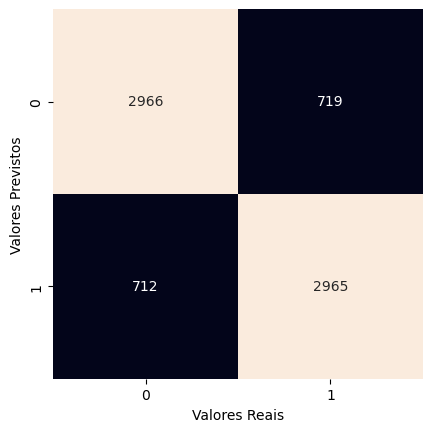

Quant. Transações Bloqueados:  3677 
Sendo 19.364% bloqueadas incorretamente e 80.636% bloqueadas corretamente
AUC: 0.806


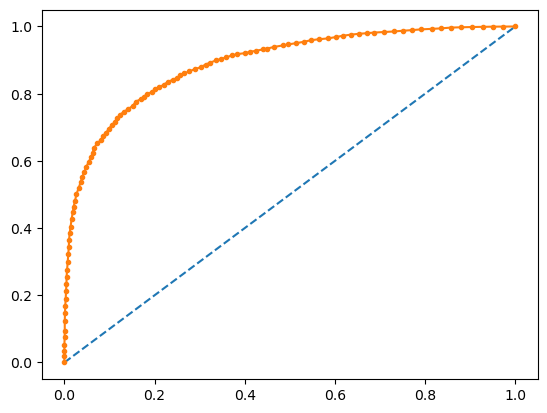

Fim: Extra Trees, Oversampling Median
Início: Extra Trees, Oversampling Predictions


C:\Users\hroat\AppData\Local\Temp\ipykernel_19728\1756800167.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(feature_vector_train, label)


train time: 1.474s
test time:  0.157s
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3678
           1       0.81      0.81      0.81      3684

    accuracy                           0.81      7362
   macro avg       0.81      0.81      0.81      7362
weighted avg       0.81      0.81      0.81      7362



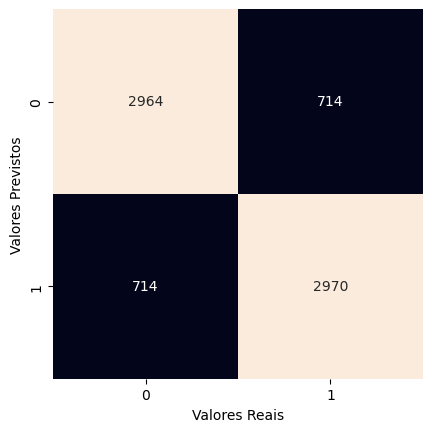

Quant. Transações Bloqueados:  3684 
Sendo 19.381% bloqueadas incorretamente e 80.619% bloqueadas corretamente
AUC: 0.806


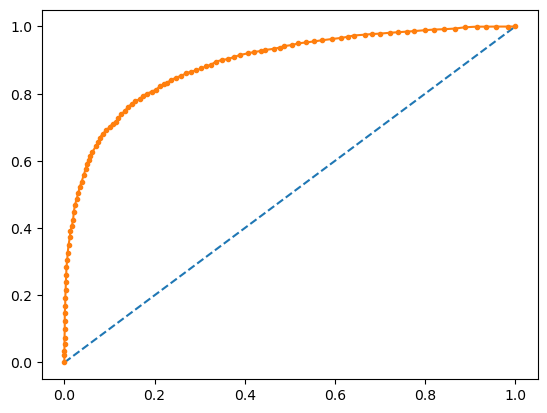

Fim: Extra Trees, Oversampling Predictions
----------------------------------------------------------------------------------------------------


In [45]:
# Dicionário para armazenamento das métricas avaliativas para comparação
resultados = {"Nome": [],
              "T. Treino": [],
              "T. Teste": [],
              "Transações Bloqueadas": [],
              "% Tran. Bloq. Corretamente": [],
              "% Tran. Bloq. Incorretamente": [],
              "auc": []
             }

# Loop para treinamento e teste dos modelos, e plotagem dos gráficos
for name, model in estimators:
    print("-"*100)
    for dataset_name, X, y in datasets:
        if (name in ["Random Forest", "Decision Tree", "Extra Trees"]) and ("Missing" in dataset_name):
            continue        
        
        resultados["Nome"].append(f"{name}, {dataset_name}")        
        print(f"Início: {name}, {dataset_name}")
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, train_size = 0.7, random_state=my_ramdom_state)
        predicoes, modelo, train_time, test_time, total_blocked, ratio_correct, ratio_incorrect \
        = train_model(model, X_train, y_train, X_test)
        
        resultados["T. Treino"].append(train_time)
        resultados["T. Teste"].append(test_time)
        resultados["Transações Bloqueadas"].append(total_blocked)
        resultados["% Tran. Bloq. Corretamente"].append(ratio_correct)
        resultados["% Tran. Bloq. Incorretamente"].append(ratio_incorrect)
        
        auc = curva_roc(modelo, X_test, y_test, predicoes)
        resultados["auc"].append(auc)
        print(f"Fim: {name}, {dataset_name}")
    print("-"*100)

# Fim da Modelagem

# Início da Avaliação dos Modelos

<p>No tabela a seguir é possível verificar e comparar todos os modelos treinados, bem como as métricas utilizadas para avaliação. É importante ressaltar que para esse experimento, os modelos foram treinados com tamanhos de amostras distintas, não permitindo que seja feita comparação em números absolutos. Além disso, optou-se por não separar o conjunto de dados em treino, validação e teste, visto que o número de amostras não se igualaria, dado as técnicas de balanceamento de classes utilizadas. Entretanto, é importante que se tenha um conjunto de validação único para comparação e decisão de qual modelo entraria para produção.</p>

In [46]:
df_resultados = pd.DataFrame(resultados)
df_resultados

,Nome,T. Treino,T. Teste,Transações Bloqueadas,% Tran. Bloq. Corretamente,% Tran. Bloq. Incorretamente,auc
0,"XGBoost, Original Missing",1.743844,0.000000,906,71.633554,28.366446,0.696365
1,"XGBoost, Original Mean",0.470744,0.000000,892,71.748879,28.251121,0.693838
2,"XGBoost, Original Median",0.470752,0.000000,877,72.862030,27.137970,0.695393
3,"XGBoost, Original Predictions",0.486409,0.000000,861,71.777003,28.222997,0.687221
4,"XGBoost, Undersampling Missing",0.363092,0.000000,1356,74.410029,25.589971,0.734840
5,"XGBoost, Undersampling Mean",0.298080,0.000000,1337,75.018699,24.981301,0.737432
6,"XGBoost, Undersampling Median",0.361006,0.000000,1341,75.167785,24.832215,0.739587
7,"XGBoost, Undersampling Predictions",0.298090,0.015616,1326,74.208145,25.791855,0.727709
8,"XGBoost, Oversampling Missing",0.706359,0.015624,3416,85.685012,14.314988,0.830782
9,"XGBoost, Oversampling Mean",0.768879,0.000000,3553,84.041655,15.958345,0.828186


In [47]:
# Recupera o top-2 de cada grupo
df_geral = df_resultados.nlargest(2, ["% Tran. Bloq. Corretamente", "auc"])
df_original = df_resultados.loc[df_resultados['Nome'].str.contains("Original")].nlargest(2, ["% Tran. Bloq. Corretamente", "auc"])
df_under = df_resultados.loc[df_resultados['Nome'].str.contains("Undersampling")].nlargest(2, ["% Tran. Bloq. Corretamente", "auc"])
df_over = df_resultados.loc[df_resultados['Nome'].str.contains("Oversampling")].nlargest(2, ["% Tran. Bloq. Corretamente", "auc"])

<p>Para selecionar os modelos e seguir para a validação cruzada, criei uma regra de seleção onde:</p>
<ul>
    <li>Através maior porcentagem de bloqueios e melhor AUC</li>
    <ol>
        <li>Busca os 2 melhores modelos no geral;</li>
        <li>Busca os 2 melhores modelos no conjunto de dados original;</li>
        <li>Busca os 2 melhores modelos no conjunto de dados rebalanceado com undersampling;</li>
        <li>Busca os 2 melhores modelos no conjunto de dados rebalanceado com overersampling;</li>
    </ol>
</ul>
<p>Com esses modelos selecionados, é realizada a validação cruzada com 10-Fold.</p>
<p>As métricas de sensibilidade, especificidade e AUC (área sob a curva ROC) são frequentemente usadas para avaliar o desempenho de modelos de detecção de fraudes financeiras. Essas métricas podem fornecer informações importantes sobre a capacidade do modelo de identificar transações fraudulentas e minimizar perdas financeiras.</p>

<p>A sensibilidade mede a proporção de transações fraudulentas que foram corretamente identificadas pelo modelo. Um modelo com alta sensibilidade é capaz de detectar a maioria das transações fraudulentas e, portanto, pode reduzir as perdas financeiras associadas a fraudes não detectadas.</p>

<p>A especificidade mede a proporção de transações legítimas que foram corretamente identificadas pelo modelo. Um modelo com alta especificidade é capaz de identificar a maioria das transações legítimas e, portanto, pode ajudar a evitar bloqueios desnecessários de transações legítimas, minimizando as perdas financeiras associadas a esses bloqueios.</p>

<p>A AUC mede a capacidade geral do modelo de distinguir entre transações fraudulentas e legítimas. Um modelo com alta AUC é capaz de fazer classificações precisas em uma ampla variedade de pontos de corte e, portanto, pode ser mais eficaz na identificação de fraudes e na minimização de perdas financeiras.</p>

<p>Em geral, um modelo de detecção de fraude financeira deve ter alta sensibilidade para minimizar as perdas financeiras associadas a fraudes não detectadas e alta especificidade para minimizar as perdas financeiras associadas a bloqueios desnecessários de transações legítimas. A AUC pode ser usada como uma métrica geral para avaliar a capacidade geral do modelo de fazer classificações precisas em uma ampla variedade de pontos de corte.</p>

<p>No entanto, é importante lembrar que o desempenho do modelo de detecção de fraude financeira também pode ser afetado por outros fatores, como o custo de bloquear uma transação legítima versus permitir uma transação fraudulenta e a gravidade das consequências de uma fraude não detectada. Por isso, é importante considerar não apenas as métricas de desempenho do modelo, mas também as necessidades específicas do negócio ao avaliar a eficácia do modelo em gerar lucros ou evitar perdas.</p>

<h4>Para esse experimento, decidi focar na AUC e na porcentagem de fraudes bloqueadas corretamente.</h4>

In [48]:
# Une os dataframes com as seleções
df_selecionados = pd.concat([df_geral, df_original, df_under, df_over])
df_selecionados.drop_duplicates(inplace=True)
df_selecionados = df_selecionados.sort_index()
df_selecionados

,Nome,T. Treino,T. Teste,Transações Bloqueadas,% Tran. Bloq. Corretamente,% Tran. Bloq. Incorretamente,auc
5,"XGBoost, Undersampling Mean",0.298080,0.000000,1337,75.018699,24.981301,0.737432
6,"XGBoost, Undersampling Median",0.361006,0.000000,1341,75.167785,24.832215,0.739587
8,"XGBoost, Oversampling Missing",0.706359,0.015624,3416,85.685012,14.314988,0.830782
13,"LGBM, Original Mean",0.094154,0.015626,840,74.880952,25.119048,0.695513
15,"LGBM, Original Predictions",0.094166,0.015625,799,74.342929,25.657071,0.683850
20,"LGBM, Oversampling Missing",0.141043,0.015625,3392,85.524764,14.475236,0.826981


### Início - Validação Cruzada

In [49]:
# Dicionário para armazenamento das métricas avaliativas para comparação
resultados_cross = {"Nome": [],
                    "T. Treino": [],
                    "T. Teste": [],
                    "Transações Bloqueadas": [],
                    "% Tran. Bloq. Corretamente": [],
                    "% Tran. Bloq. Incorretamente": [],
                    "auc": []
                    }

----------------------------------------------------------------------------------------------------
Início: XGBoost, Undersampling Mean
train time: 0.314s
test time:  5.603s
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1371
           1       0.73      0.72      0.72      1396

    accuracy                           0.72      2767
   macro avg       0.72      0.72      0.72      2767
weighted avg       0.72      0.72      0.72      2767



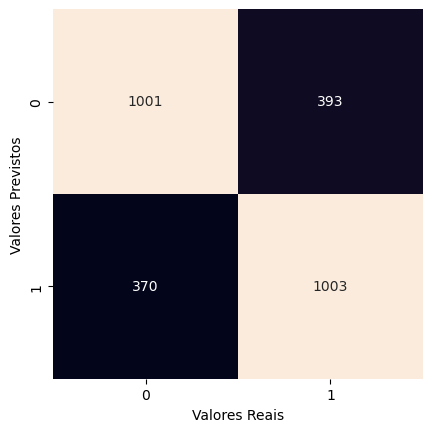

Quant. Transações Bloqueados:  1373 
Sendo 26.948% bloqueadas incorretamente e 73.052% bloqueadas corretamente
AUC: 0.724


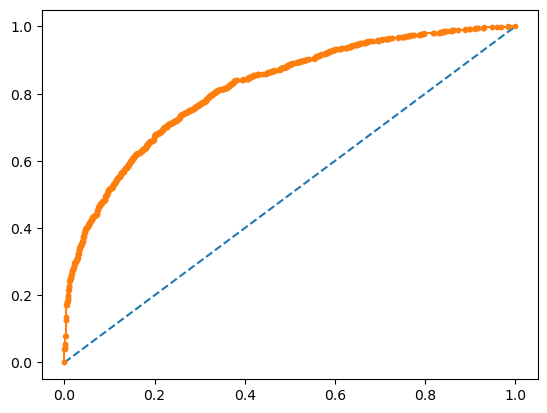

Fim: XGBoost, Undersampling Mean
Início: XGBoost, Undersampling Median
train time: 0.408s
test time:  0.941s
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1371
           1       0.72      0.71      0.72      1396

    accuracy                           0.71      2767
   macro avg       0.71      0.71      0.71      2767
weighted avg       0.71      0.71      0.71      2767



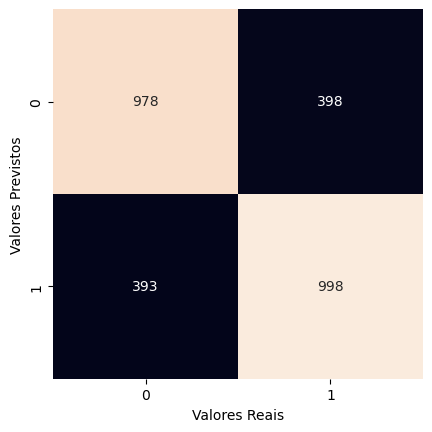

Quant. Transações Bloqueados:  1391 
Sendo 28.253% bloqueadas incorretamente e 71.747% bloqueadas corretamente
AUC: 0.714


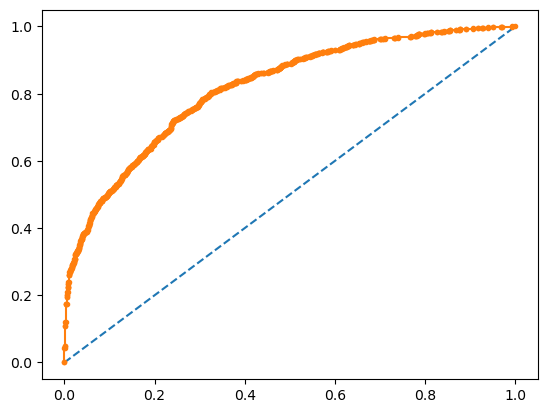

Fim: XGBoost, Undersampling Median
Início: XGBoost, Oversampling Missing
train time: 0.784s
test time:  2.731s
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      3678
           1       0.84      0.79      0.82      3684

    accuracy                           0.82      7362
   macro avg       0.82      0.82      0.82      7362
weighted avg       0.82      0.82      0.82      7362



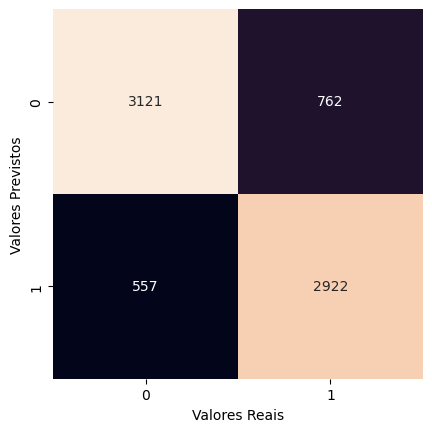

Quant. Transações Bloqueados:  3479 
Sendo 16.010% bloqueadas incorretamente e 83.990% bloqueadas corretamente
AUC: 0.821


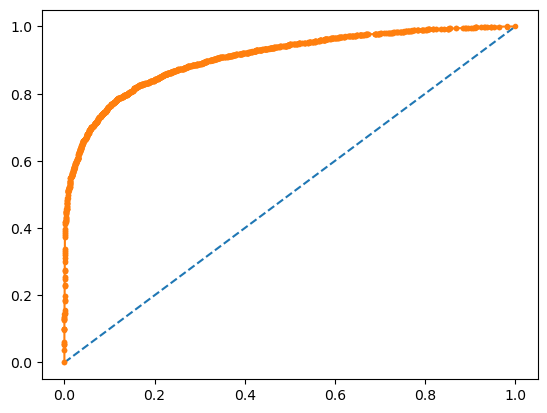

Fim: XGBoost, Oversampling Missing
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Início: LGBM, Original Mean
train time: 0.141s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test time:  1.929s
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      3662
           1       0.69      0.43      0.53      1402

    accuracy                           0.79      5064
   macro avg       0.75      0.68      0.70      5064
weighted avg       0.78      0.79      0.77      5064



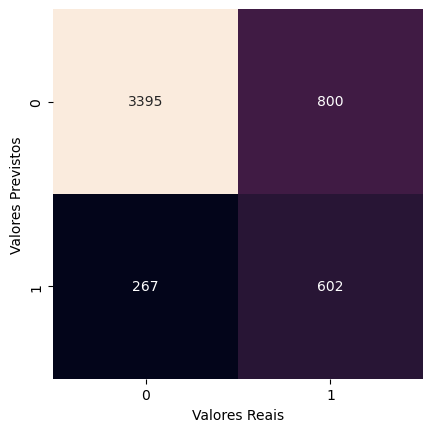

Quant. Transações Bloqueados:  869 
Sendo 30.725% bloqueadas incorretamente e 69.275% bloqueadas corretamente
AUC: 0.678


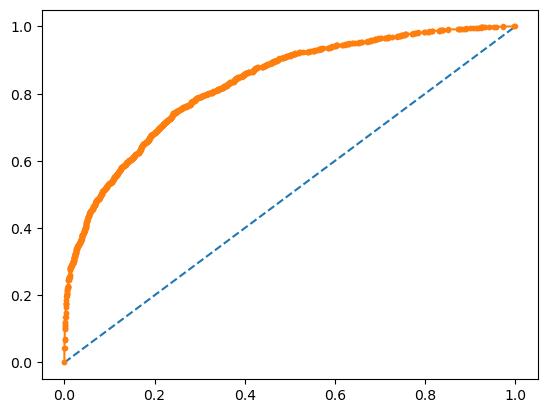

Fim: LGBM, Original Mean
Início: LGBM, Original Predictions
train time: 0.125s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test time:  0.299s
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      3662
           1       0.69      0.42      0.52      1402

    accuracy                           0.79      5064
   macro avg       0.75      0.67      0.69      5064
weighted avg       0.77      0.79      0.77      5064



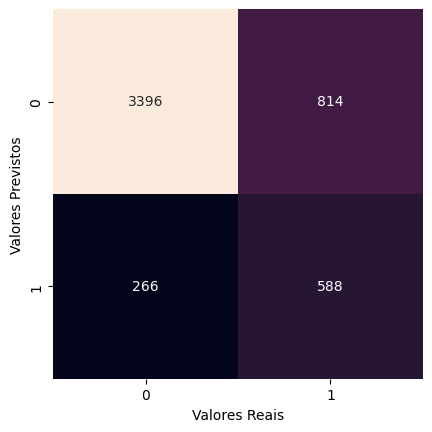

Quant. Transações Bloqueados:  854 
Sendo 31.148% bloqueadas incorretamente e 68.852% bloqueadas corretamente
AUC: 0.673


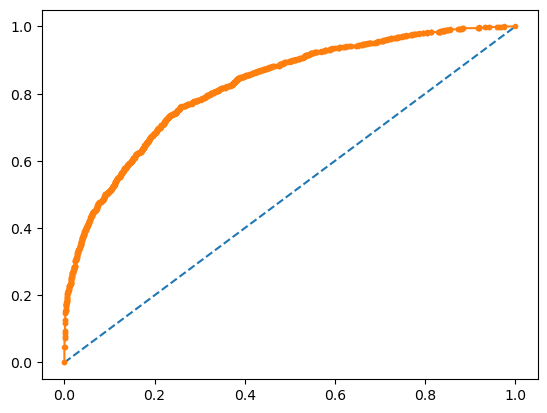

Fim: LGBM, Original Predictions
Início: LGBM, Oversampling Missing
train time: 0.141s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test time:  0.408s
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3678
           1       0.85      0.78      0.81      3684

    accuracy                           0.82      7362
   macro avg       0.82      0.82      0.82      7362
weighted avg       0.82      0.82      0.82      7362



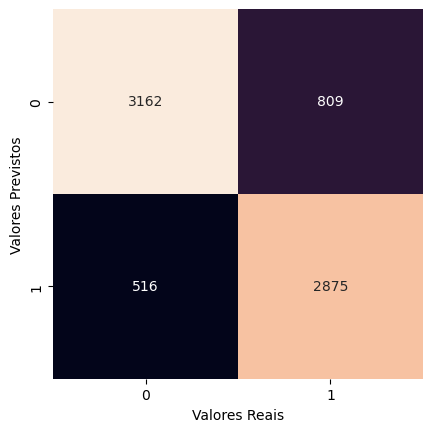

Quant. Transações Bloqueados:  3391 
Sendo 15.217% bloqueadas incorretamente e 84.783% bloqueadas corretamente
AUC: 0.820


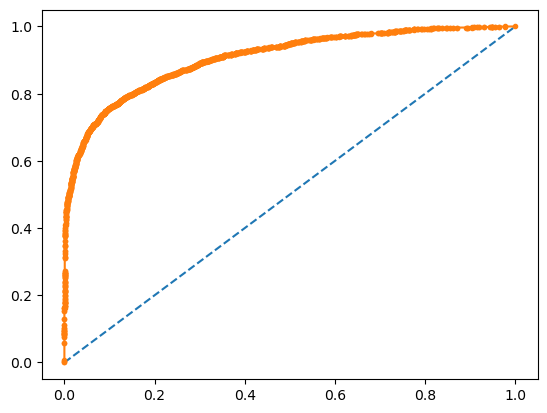

Fim: LGBM, Oversampling Missing
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [50]:
for name, model in estimators:
    print("-"*100)
    for dataset_name, X, y in datasets:
        if f"{name}, {dataset_name}" in df_selecionados.Nome.unique():
            if (name in ["Random Forest", "Decision Tree", "Extra Trees"]) and ("Missing" in dataset_name):
                continue        

            resultados_cross["Nome"].append(f"{name}, {dataset_name}")        
            print(f"Início: {name}, {dataset_name}")

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, train_size = 0.7, random_state=my_ramdom_state)
            predicoes, modelo, train_time, test_time, total_blocked, ratio_correct, ratio_incorrect \
            = train_model(model, X_train, y_train, X_test, y_test, is_cross_validate=True)

            resultados_cross["T. Treino"].append(train_time)
            resultados_cross["T. Teste"].append(test_time)
            resultados_cross["Transações Bloqueadas"].append(total_blocked)
            resultados_cross["% Tran. Bloq. Corretamente"].append(ratio_correct)
            resultados_cross["% Tran. Bloq. Incorretamente"].append(ratio_incorrect)

            auc = curva_roc(modelo, X_test, y_test, predicoes)
            resultados_cross["auc"].append(auc)
            print(f"Fim: {name}, {dataset_name}")
    print("-"*100)

In [51]:
df_resultados_cross = pd.DataFrame(resultados_cross)
df_resultados_cross.sort_values(by=["% Tran. Bloq. Corretamente", "auc"], ascending=False)

,Nome,T. Treino,T. Teste,Transações Bloqueadas,% Tran. Bloq. Corretamente,% Tran. Bloq. Incorretamente,auc
5,"LGBM, Oversampling Missing",0.141423,0.407902,3391,84.783250,15.216750,0.820054
2,"XGBoost, Oversampling Missing",0.784473,2.730660,3479,83.989652,16.010348,0.820859
0,"XGBoost, Undersampling Mean",0.313693,5.603080,1373,73.051712,26.948288,0.724303
1,"XGBoost, Undersampling Median",0.407612,0.941117,1391,71.746945,28.253055,0.714124
3,"LGBM, Original Mean",0.141036,1.929259,869,69.275029,30.724971,0.678238
4,"LGBM, Original Predictions",0.125404,0.298529,854,68.852459,31.147541,0.673381


<p>Para selecionar o modelo que irá para produção, criei uma regra de seleção onde:</p>
<ul>
    <li>Através do melhor tempo de treino e teste, maior número de bloqueios, maior porcentagem de bloqueios e melhor AUC</li>
    <ol>
        <li>Busca o melhor modelo no geral;</li>
        <li>Busca o melhor modelo no conjunto de dados original;</li>
        <li>Busca o melhor modelo no conjunto de dados rebalanceado com undersampling;</li>
        <li>Busca o melhor modelo no conjunto de dados rebalanceado com overersampling;</li>
    </ol>
</ul>
<p>A partir desses modelos, seleciona-se o melhor custo benefício. Ou seja, o que prevê melhor as transações fraudulentas.</p>

In [52]:
df_geral_cross = compare(df_resultados=df_resultados_cross)
df_geral_cross.sort_values(by=["% Tran. Bloq. Corretamente", "auc"], ascending=False)

GERAL
Modelo com treino mais rápido: LGBM, Original Predictions
Modelo com teste mais rápido: LGBM, Original Predictions
Modelo com maior número de bloqueios: XGBoost, Oversampling Missing
Modelo com maior porcentagem de bloqueios corretos: LGBM, Oversampling Missing
Modelo com melhor taxa de AUC: XGBoost, Oversampling Missing


,Nome,T. Treino,T. Teste,Transações Bloqueadas,% Tran. Bloq. Corretamente,% Tran. Bloq. Incorretamente,auc
5,"LGBM, Oversampling Missing",0.141423,0.407902,3391,84.783250,15.216750,0.820054
2,"XGBoost, Oversampling Missing",0.784473,2.730660,3479,83.989652,16.010348,0.820859
4,"LGBM, Original Predictions",0.125404,0.298529,854,68.852459,31.147541,0.673381


### Fim - Validação Cruzada

# Fim da Avaliação dos Modelos

# Conclusão

<p>Com o pipeline construído anteriormente, foram efetuados 30 experimentos. Desses, dois modelos se destacaram, aparecendo na seleção final. São eles: <strong>LGBM, Oversampling Missing</strong> e <strong>XGBoost, Oversampling Missing</strong>.</p>
<p>De acordo com os dados obtidos, ambos tem a possibilidade de maximizar os lucros (ou mitigar as perdas), detectando corretamente uma média de <strong>~85%</strong> de transações bloqueadas corretamente, com AUC de <strong>~82%</strong>.</p>

In [53]:
df_top2 = pd.read_csv("../Datasets/Top-2_Algoritmos_Pos_Crossvalidation.csv", sep=";")

In [54]:
df_top2.groupby(by="Nome").agg({"% Tran. Bloq. Corretamente":['mean', 'std', 'max', 'min', 'count'],
                                "auc":['mean', 'std', 'max', 'min', 'count'],
                               }).reset_index()

Nome % Tran. Bloq. Corretamente            \
                                                       mean       std   
0     LGBM, Oversampling Missing                  84.783250  0.000000   
1  XGBoost, Oversampling Missing                  84.299494  0.220286   

                                    auc                                      
         max        min count      mean       std       max       min count  
0  84.783250  84.783250    30  0.820054  0.000000  0.820054  0.820054    30  
1  84.651435  83.753989    30  0.819845  0.001449  0.822222  0.815701    30

<p>Da tabela acima, podemos perceber que o <strong>LGBM, Oversampling Missing</strong> é mais consistente do que o <i><strong>XGBoost, Oversampling Missing</strong></i>, visto que em todas as trinta execuções foram obtidas as mesmas métricas, confirmadas pelos seus máximo, mínimo, média e, principalmente, desvio padrão que é igual a 0(zero).</p>
<p>Dessa forma, a sugestão de implementação seria do modelo <strong>LGBM</strong> com aplicação da estratégia de balanceamento de classes Oversampling, mantendo os dados ausentes no atributo C e removendo o atributo K.</p>

<p>Ainda há outras possibilidades de melhoria para esse processo que podem ser aplicadas, como a utilização de padronização dos atributos, tendo observado que eles possuem grandezas distintas. Outra possibilidade de melhoria, é a realização de feature select, podendo ser utilizada uma estratégia automatizada ou, com o auxílio de algum especialista da área, em um processo semi-automatizado, onde indicaria a importância de cada feature detectada por algum modelo de aprendizagem de máquina e cruzaria com a necessidade do negócio em manter ou remover determinadas features. Uma terceira possibilidade seria, criando um modelo específico por país, porém haveria a necessidade de mais amostras para implementação, para que os modelos possam generalizar melhor suas previsões.</p>
<p>De qualquer forma, o experimento demonstrou que é possível criar um modelo de aprendizagem de máquina que possa, automaticamente, indicar se uma determinada transação é ou não é fraudulenta. O passo seguinte seria deixar que a transação seja bloqueada automaticamente ou encaminhar para um especialista humano seguir com a tratativa. Dado o número de transações diárias, a sugestão é de que seja feita automaticamente, desonerando o especialista humano nesse processo.</p>